In [ ]:
# Imports
import torch
from torch.utils import data
from torchvision.models import resnet18
from torch.utils.data import TensorDataset
from torchvision.utils import save_image
import torch.nn.functional as F
import torch.nn as nn
from torch import nn, optim
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import numpy as np
import glob
import pdb
import os
import matplotlib.pyplot as plt



In [ ]:

! pip install pytorch-fid
! pip install scipy==1.11.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 42.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
gpu_id = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Downloading dataset

In [ ]:
!gdown 17PHV8ARaHnrbIy-xUQ-QpJadKG-7b3FX
!gdown 1so6AQ0_Pg255COjAzEOOVPlDzTJFVQro
!gdown 1-DfoLBP9HPG1D0APeSLYmtk4rfWqMvjS

Downloading...
From: https://drive.google.com/uc?id=17PHV8ARaHnrbIy-xUQ-QpJadKG-7b3FX
To: /content/Copy of cyclegan_files.zip
100% 2.67k/2.67k [00:00<00:00, 12.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1so6AQ0_Pg255COjAzEOOVPlDzTJFVQro
To: /content/test_case.zip
100% 78.8M/78.8M [00:00<00:00, 84.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-DfoLBP9HPG1D0APeSLYmtk4rfWqMvjS
To: /content/edges2shoes-dataset.zip
100% 2.19G/2.19G [00:50<00:00, 43.2MB/s]


In [ ]:
!unzip edges2shoes-dataset

Streaming output truncated to the last 5000 lines.
  inflating: train/5681_AB.jpg       
  inflating: train/5682_AB.jpg       
  inflating: train/5683_AB.jpg       
  inflating: train/5684_AB.jpg       
  inflating: train/5685_AB.jpg       
  inflating: train/5686_AB.jpg       
  inflating: train/5687_AB.jpg       
  inflating: train/5688_AB.jpg       
  inflating: train/5689_AB.jpg       
  inflating: train/568_AB.jpg        
  inflating: train/5690_AB.jpg       
  inflating: train/5691_AB.jpg       
  inflating: train/5692_AB.jpg       
  inflating: train/5693_AB.jpg       
  inflating: train/5694_AB.jpg       
  inflating: train/5695_AB.jpg       
  inflating: train/5696_AB.jpg       
  inflating: train/5697_AB.jpg       
  inflating: train/5698_AB.jpg       
  inflating: train/5699_AB.jpg       
  inflating: train/569_AB.jpg        
  inflating: train/56_AB.jpg         
  inflating: train/5700_AB.jpg       
  inflating: train/5701_AB.jpg       
  inflating: train/5702_AB.jpg       

# Defining Hyper parameters

In [ ]:
num_epochs = 20
batch_size = 8
lr_rate = 2e-4  	      # Adam optimizer learning rate
betas = (0.5, 0.999)			  # Adam optimizer beta 1, beta 2
lambda_pixel =  10      # Loss weights for pixel loss
lambda_latent = 0.5    # Loss weights for latent regression
lambda_kl =  0.01      # Loss weights for kl divergence
latent_dim =   8       # latent dimension for the encoded images from domain B



# Creating dataloaders

In [ ]:
class Edge2Shoe(data.Dataset):
	""" Dataloader for Edge2Shoe datasets
		Note: we resize images (original 256x256) to 128x128 for faster training purpose

		Args:
			img_dir: path to the dataset

	"""
	def __init__(self, img_dir):
		image_list = []
		for img_file in glob.glob(str(img_dir)+'*'):
			image_list.append(img_file)
		self.image_list = image_list

	def __getitem__(self, index):
		image = Image.open(self.image_list[index]).resize((256,128), resample=Image.BILINEAR)
		image = np.asarray(image).transpose(2,0,1)
		image_tensor = torch.from_numpy(image).float()
		edge_tensor = image_tensor[:,:,:128]; rgb_tensor = image_tensor[:,:,128:]
		return edge_tensor, rgb_tensor

	def __len__(self):
		return len(self.image_list)

# Creating Encoder

In [ ]:
##############################
#        Encoder
##############################
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        """ The encoder used in both cVAE-GAN and cLR-GAN, which encode image B or B_hat to latent vector
            This encoder uses resnet-18 to extract features, and further encode them into a distribution
            similar to VAE encoder.

            Note: You may either add "reparametrization trick" and "KL divergence" or in the train.py file

            Args in constructor:
                latent_dim: latent dimension for z

            Args in forward function:
                img: image input (from domain B)

            Returns:
                mu: mean of the latent code
                logvar: sigma of the latent code
        """

        # Extracts features at the last fully-connected
        resnet18_model = resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet18_model.children())[:-3])
        self.pooling = nn.AvgPool2d(kernel_size=8, stride=8, padding=0)

        # Output is mu and log(var) for reparameterization trick used in VAEs
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def reparameterization(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def forward(self, img):
        out = self.feature_extractor(img)
        out = self.pooling(out)
        out = out.view(out.size(0), -1)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        z = self.reparameterization(mu,logvar)

        return z,mu,logvar



# Creating Generator

In [ ]:
# This is similar to Cyclegan generator except we incorporate latent dimension
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, latent_dim, input_shape, num_residual_blocks, device='cuda'):
        super(Generator, self).__init__()

        self.device = device

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels + latent_dim, out_features, 7),
            # nn.InstanceNorm2d(out_features),
            #nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x: torch.Tensor, z: torch.Tensor):
        z_img = z.view(z.size(0), z.size(1), 1, 1).expand(
            z.size(0), z.size(1), x.size(2), x.size(3))
        out = torch.cat([x, z_img], dim=1)
        return self.model(out)

# Creating Discriminator

In [ ]:
##############################
#        Discriminator
##############################
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
          super(Discriminator, self).__init__()
          """ The discriminator used in both cVAE-GAN and cLR-GAN
          This code implements a 70x70 patchGAN

              Args in constructor:
                  in_channels: number of channel in image (default: 3 for RGB)

              Args in forward function:
                  x: image input (real_B, fake_B)

              Returns:
                  discriminator output: could be a single value or a matrix depending on the type of GAN
          """
          # Convolutional layers
          self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1)
          self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
          self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
          self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1)

          # Final convolutional layer for patch classification
          self.patch_classifier = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

          # Activation function (Leaky ReLU)
          self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

          # Batch normalization
          self.batch_norm2d_1 = nn.BatchNorm2d(128)
          self.batch_norm2d_2 = nn.BatchNorm2d(256)

          # Number of patches to classify

    def forward(self, x):
          x = self.leaky_relu(self.conv1(x))
          x = self.leaky_relu(self.batch_norm2d_1(self.conv2(x)))
          x = self.leaky_relu(self.batch_norm2d_2(self.conv3(x)))
          x = self.leaky_relu(self.conv4(x))

          # Patch classification
          patch_scores = self.patch_classifier(x)

          return patch_scores

# Defining losses & necessary functions

In [ ]:
batch_size = 8
n_residual_blocks = 6
img_shape = (3, 128, 128)
img_dir = "/content/train/"

# Normalize image tensor
def norm(image):
	return (image/255.0-0.5)*2.0

# Denormalize image tensor
def denorm(tensor):
	return ((tensor+1.0)/2.0)*255.0

# Random seeds (optional)
torch.manual_seed(1); np.random.seed(1)

# Define DataLoader
dataset = Edge2Shoe(img_dir)
loader = data.DataLoader(dataset, batch_size=batch_size)

# Loss functions
mae_loss = torch.nn.L1Loss().to(gpu_id)
mse_loss = torch.nn.MSELoss().to(gpu_id)

# For adversarial loss (optional to use)
valid = 1; fake = 0

# Function to plot loss during training

In [ ]:
def plot_loss(total_loss_history,loss_cvaegan_l1_history,
             loss_KLD_history,loss_D_loss_cVAE_history,
             loss_D_loss_cLRGAN_history,
             loss_clrgan_l1_history,loss_vae_gan_loss_history,loss_LR_GAN_loss_history):
    for loss_ind in range(len([total_loss_history,loss_cvaegan_l1_history,
             loss_KLD_history,loss_D_loss_cVAE_history,
             loss_D_loss_cLRGAN_history,
             loss_clrgan_l1_history,
             loss_vae_gan_loss_history,
             loss_LR_GAN_loss_history])):

        loss = [total_loss_history,loss_cvaegan_l1_history,
                loss_KLD_history,loss_D_loss_cVAE_history,
                loss_D_loss_cLRGAN_history,
                loss_clrgan_l1_history,loss_vae_gan_loss_history,loss_LR_GAN_loss_history][loss_ind]
        #print(loss)

        key = ["total_loss_history","loss_cvaegan_l1_history",
                "loss_KLD_history","loss_D_loss_cVAE_history",
                "loss_D_loss_cLRGAN_history",
                "loss_clrgan_l1_history","loss_vae_gan_loss_history","loss_LR_GAN_loss_history"]

        plt.plot(loss,label = key[loss_ind])

        plt.legend()
        plt.show()

# Function to visualize diverse generator images for a randomly drawn vector

In [ ]:
def plot_sketch_to_multimodal(generator,sketch,z_dim,n=5):
    sketches = sketch.repeat(n,1,1,1)
    z_random = torch.randn(n,z_dim).to(gpu_id)
    #print(z_random)
    out = generator(sketches,z_random)

    fig, axs = plt.subplots(1,6, figsize = (15,90
                                            ))
    axs[0].imshow(sketch.detach().cpu().numpy().transpose(1,2,0))
    axs[0].set_title('Sketch')
    for i in range(1,n+1):
        img = denorm(out[i-1].squeeze()).cpu().data.numpy().astype(np.uint8)
        axs[i].imshow(img.transpose(1,2,0))  #real sketch
        axs[i].set_title(f'Colored image {i}')

    plt.show()


# Function to calculate Discriminator Loss

In [ ]:
def calculate_D_loss(fake_B, D, real_B):

    # forward real_B images into the discriminator
    real_D_scores = D(real_B)
    # compute loss between Valid_label and discriminator output on real_B images
    mse_loss_real = mse_loss(real_D_scores, torch.ones_like(real_D_scores))

    # Compute loss between Fake_label and discriminator output on fake images
    fake_D_scores = D(fake_B.detach())
    mse_loss_fake = mse_loss(fake_D_scores, torch.zeros_like(fake_D_scores))
    # sum real_B loss and fake loss as the loss_D
    loss_discriminator = mse_loss_real + mse_loss_fake

    return loss_discriminator


# Model training function

Create a checkpointing folder before hand following the path used in the code below

In [ ]:
def train(argpath = None, ckt_path = None):
    if argpath is not None:
        img_dir = argpath
        dataset = Edge2Shoe(img_dir)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    total_steps = len(loader)*num_epochs; step = 0
    report_feq = 1000
    save_feq = 6229
    start_epoch = 0

    # Define generator, encoder and discriminators object
    generator = Generator(latent_dim, img_shape, n_residual_blocks, device=gpu_id).to(gpu_id)
    encoder = Encoder(latent_dim).to(gpu_id)
    D_VAE = Discriminator().to(gpu_id)
    D_LR = Discriminator().to(gpu_id)

    # Define optimizers for networks
    optimizer_E = torch.optim.Adam(encoder.parameters(), lr=lr_rate, betas=betas)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_rate, betas=betas)
    optimizer_D_VAE = torch.optim.Adam(D_VAE.parameters(), lr=lr_rate, betas=betas)
    optimizer_D_LR = torch.optim.Adam(D_LR.parameters(), lr=lr_rate, betas=betas)

    #Initialzing empty loss histories. If checkpoint present, they get replaced below
    total_loss_history = []
    loss_cvaegan_l1_history = []
    loss_KLD_history = []
    loss_D_loss_cVAE_history = []
    loss_D_loss_cLRGAN_history = []
    loss_clrgan_l1_history = []
    loss_vae_gan_loss_history = []
    loss_LR_GAN_loss_history = []

    #Load checkpoint if path is given
    if ckt_path:
        if os.path.isfile(ckt_path):
            print(f"Loading checkpoint '{ckt_path}'")
            ckt = torch.load(ckt_path)
            #load losses
            total_loss_history = ckt['loss_total']
            #print("checkpointed total loss history : ",total_loss_history)
            loss_cvaegan_l1_history = ckt['cvaegan_l1']
            loss_KLD_history = ckt['KLD']
            loss_D_loss_cVAE_history = ckt['D_loss_cVAE']
            loss_D_loss_cLRGAN_history =ckt['D_loss_cLRGAN']
            loss_clrgan_l1_history = ckt['clrgan_l1']
            loss_vae_gan_loss_history = ckt['VAE_GAN_loss']
            loss_LR_GAN_loss_history = ckt['LR_GAN_loss']
            #load gen,disc,encoder objects
            generator.load_state_dict(ckt['generator'])
            encoder.load_state_dict(ckt['encoder'])
            D_VAE.load_state_dict(ckt['D_VAE'])
            D_LR.load_state_dict(ckt['D_LR'])
            #load optimizers
            optimizer_G.load_state_dict(ckt['optimizer_G'])
            optimizer_E.load_state_dict(ckt['optimizer_E'])
            optimizer_D_VAE.load_state_dict(ckt['optimizer_D_VAE'])
            optimizer_D_LR.load_state_dict(ckt['optimizer_D_LR'])
            #load epoch
            start_epoch = ckt['epoch'] + 1
            print(f"Resuming training from epoch {start_epoch}")
        else:
          print("checkpoint file corrupted")
    else:
      print("No checkpoints detected. Starting from scratch")

    #common code irrespective of checkpoint
    running_total_loss = 0
    running_loss_cvaegan_l1 = 0
    running_loss_KLD = 0
    running_loss_D_loss_cVAE = 0
    running_loss_D_loss_cLRGAN = 0
    running_loss_clrgan_l1 = 0
    running_loss_vae_gan_loss = 0
    running_loss_LR_GAN_loss = 0

    for e in range(start_epoch, num_epochs):
        tqdm_loader = tqdm(loader, total=len(loader))
        for idx, data in enumerate(tqdm_loader):
            edge_tensor, rgb_tensor = data
            edge_tensor, rgb_tensor = norm(edge_tensor).to(gpu_id), norm(rgb_tensor).to(gpu_id)
            real_A = edge_tensor
            real_B = rgb_tensor

            optimizer_E.zero_grad()
            optimizer_G.zero_grad()



            # Encode real images to get latent codes (z_encoded) and their corresponding mean (mu) and log variance (logvar)
            z_encoded, mu, logvar = encoder(real_B)
            #print(z_encoded.shape) #[8,8]

            # Generate fake images from real images and latent codes - vae generator
            fake_B_vae = generator(real_A, z_encoded)

            #next use clrgan generator, encoder
            z_random = torch.randn_like(z_encoded)
            fake_B_clr = generator(real_A, z_random)
            _, mu_clr, logvar_clr2 = encoder(fake_B_clr)

            #----------------------


            #generator losses -
            #1) cvaegan adversarial loss (pass vaegan's generator generated fake image to discriminator vae and calculate adv loss)
            fake_D_VAE_scores = D_VAE(fake_B_vae)
            vae_gan_loss = mse_loss(fake_D_VAE_scores, torch.ones_like(fake_D_VAE_scores))
            # we used ones_like above as generator wants to convince disc that fake images should be predicted as 1

            #2) clrgan adversarial loss - (pass clrgan generator generated fake images to disc LR and calculate adv loss)
            fake_D_LR_scores = D_LR(fake_B_clr)
            clr_gan_loss = mse_loss(fake_D_LR_scores, torch.ones_like(fake_D_LR_scores))

            #3) KL Divergence loss
            KLD_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            #4) CVAEGAN Reconstruction Loss (L1 loss)
            cvaegan_l1 = mae_loss(fake_B_vae, real_B)

            #In all of components above, it doesnt make sense to freeze generator or encoder.
            # add all losses
            G_loss = cvaegan_l1 * lambda_pixel + KLD_loss * lambda_kl + vae_gan_loss + clr_gan_loss
            G_loss.backward(retain_graph = True)  #Here I should use retain graph
            #as below clrgan_l1 uses encoder, generator as was used by G_loss. So we should not free the computation graph


            l1_clr = mae_loss(mu_clr, z_random)
            clrgan_l1 = l1_clr * lambda_latent
            clrgan_l1.backward()

            #update optimizers
            optimizer_E.step()
            optimizer_G.step()

            #Generator, Encoder training done

            #----------------------
            #Now we train discriminator.

            optimizer_D_VAE.zero_grad()
            optimizer_D_LR.zero_grad()

            # Calculate discriminator loss for VAE-GAN
            real_D_VAE_scores = D_VAE(real_B)
            D_loss_cVAE = calculate_D_loss(fake_B_vae, D_VAE, real_B)
            D_loss_cVAE.backward()
            optimizer_D_VAE.step()

            # Calculate discriminator loss for cLR-GAN
            real_D_LR_scores = D_LR(real_B)
            D_loss_cLRGAN = calculate_D_loss(fake_B_clr, D_LR, real_B)
            D_loss_cLRGAN.backward()
            optimizer_D_LR.step()


            #add all losses
            running_total_loss += (D_loss_cVAE +D_loss_cLRGAN + cvaegan_l1*lambda_pixel + KLD_loss * lambda_kl + clrgan_l1*lambda_latent +vae_gan_loss  +clr_gan_loss).item()
            running_loss_cvaegan_l1 += cvaegan_l1.item()
            running_loss_KLD += KLD_loss.item()
            running_loss_D_loss_cVAE += D_loss_cVAE.item()
            running_loss_D_loss_cLRGAN += D_loss_cLRGAN.item()
            running_loss_clrgan_l1 += clrgan_l1.item()
            running_loss_vae_gan_loss += vae_gan_loss.item()
            running_loss_LR_GAN_loss += clr_gan_loss.item()


            step += 1

            ########## Visualization ##########
            if step % report_feq == report_feq-1:
                print('Train Epoch: {} {:.0f}% \tTotal Loss: {:.6f} \loss_cvaegan_l1: {:.6f}\loss_KLD: {:.6f}\D_loss_cVAE: {:.6f}\D_loss_cLRGAN: {:.6f}\loss_clrgan_l1: {:.6f}\VAE_GAN_loss: {:.6f}\LR_GAN_loss: {:.6f}'.format
                        (e+1, 100. * idx / len(loader), running_total_loss / report_feq,
                        running_loss_cvaegan_l1/report_feq, running_loss_KLD/report_feq,
                        running_loss_D_loss_cVAE/report_feq, running_loss_D_loss_cLRGAN/report_feq,
                        running_loss_clrgan_l1/report_feq,
                         running_loss_vae_gan_loss/report_feq,
                         running_loss_LR_GAN_loss/report_feq))

                #now store losses in list for plot
                total_loss_history.append(running_total_loss/report_feq)
                loss_cvaegan_l1_history.append(running_loss_cvaegan_l1/report_feq)
                loss_KLD_history.append(running_loss_KLD/report_feq)
                loss_D_loss_cVAE_history.append(running_loss_D_loss_cVAE/report_feq)
                loss_D_loss_cLRGAN_history.append(running_loss_D_loss_cLRGAN/report_feq)
                loss_clrgan_l1_history.append(running_loss_clrgan_l1/report_feq)
                loss_vae_gan_loss_history.append(running_loss_vae_gan_loss/report_feq)
                loss_LR_GAN_loss_history.append(running_loss_LR_GAN_loss/report_feq)

                #now reset once saved
                running_total_loss = 0
                running_loss_cvaegan_l1 = 0
                running_loss_KLD = 0
                running_loss_D_loss_cVAE = 0
                running_loss_D_loss_cLRGAN = 0
                running_loss_clrgan_l1 = 0
                running_loss_vae_gan_loss = 0
                running_loss_LR_GAN_loss = 0


                #Visualize generated images & loss
                plot_sketch_to_multimodal(generator,real_A[0],latent_dim)

                plot_loss(total_loss_history,loss_cvaegan_l1_history,
             loss_KLD_history,loss_D_loss_cVAE_history,
             loss_D_loss_cLRGAN_history,
             loss_clrgan_l1_history,
                        loss_vae_gan_loss_history,loss_LR_GAN_loss_history)

            if step % save_feq == save_feq-1:
              #Checkpointing code
              checkpoint_filename = f'checkpoint_epoch{e}_step_{step}.pt'
              checkpoint_path = os.path.join('/content/drive/MyDrive/classwork/cis680/project/checkpoints/', checkpoint_filename)
              print(f"Saving checkpoint : {checkpoint_filename} at {checkpoint_path}")

              checkpoint = {
                  #store losses list
                  "loss_total": total_loss_history,
                  "cvaegan_l1": loss_cvaegan_l1_history,
                  "KLD": loss_KLD_history,
                  "D_loss_cVAE": loss_D_loss_cVAE_history,
                  "D_loss_cLRGAN": loss_D_loss_cLRGAN_history,
                  "clrgan_l1" : loss_clrgan_l1_history,
                  "VAE_GAN_loss" : loss_vae_gan_loss_history,
                  "LR_GAN_loss" : loss_LR_GAN_loss_history,
                  #store generators, discriminators, encoders since they are getting updated in backprop
                  "generator": generator.state_dict(),
                  "encoder": encoder.state_dict(),
                  "D_VAE": D_VAE.state_dict(),
                  "D_LR": D_LR.state_dict(),
                  #store optimizer & epoch info
                  "optimizer_G" : optimizer_G.state_dict(),
                  "optimizer_E": optimizer_E.state_dict(),
                  "optimizer_D_VAE": optimizer_D_VAE.state_dict(),
                  "optimizer_D_LR" : optimizer_D_LR.state_dict(),
                  "epoch" : e

                            }

              torch.save(checkpoint, checkpoint_path)



    return total_loss_history,loss_cvaegan_l1_history,loss_KLD_history,loss_D_loss_cVAE_history,loss_D_loss_cLRGAN_history, loss_clrgan_l1_history





# Training the model

In [ ]:
%matplotlib inline
#Use below if you have checkpoint. Edit filename accordingly
#filename = f'checkpoint_epoch{0}_step_{99}.pt'
#path_to_checkpoint = os.path.join('/content/drive/MyDrive/classwork/cis680/project/checkpoints/', filename)
#total_loss_history,loss_cvaegan_l1_history,loss_KLD_history,loss_D_loss_cVAE_history,loss_D_loss_cLRGAN_history, loss_clrgan_l1_history = train("/content/train/",path_to_checkpoint)

#Use below if you dont have checkpoint
total_loss_history,loss_cvaegan_l1_history,loss_KLD_history,loss_D_loss_cVAE_history,loss_D_loss_cLRGAN_history, loss_clrgan_l1_history = train("/content/train/")


### We show loss plots and intermediate visualization in the next section. We are showing the images from our main notebook in which we trained using Colab Pro.We made this notebook for formatting purposes.Moreover, for visualization, we are showing 2 images per epoch. The sketches may not be same over all epochs as we did not do shuffle = False but the images will give a fair idea of how our model has improved over epochsshai

### Showing final plots after 12 epochs (70 iterations)

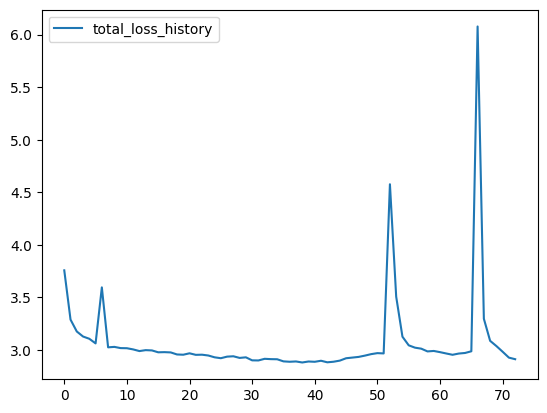

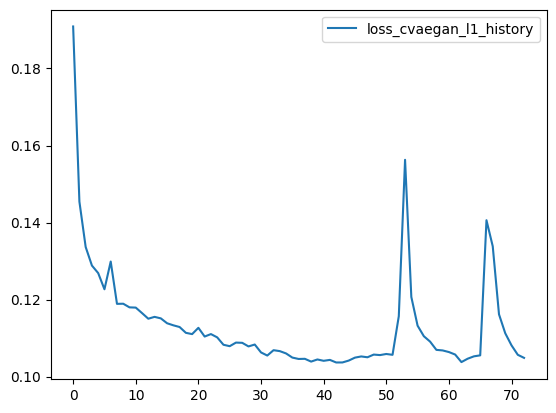

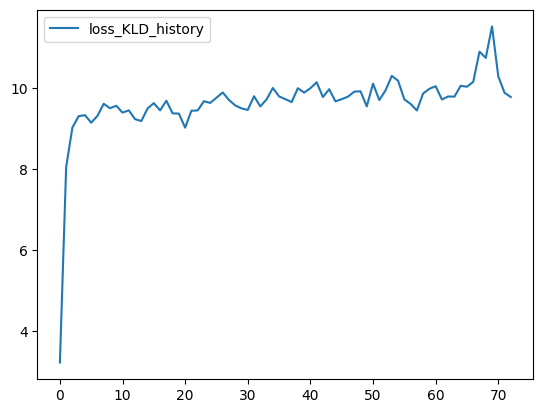

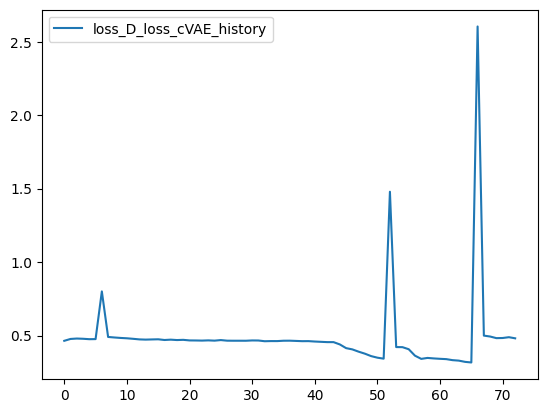

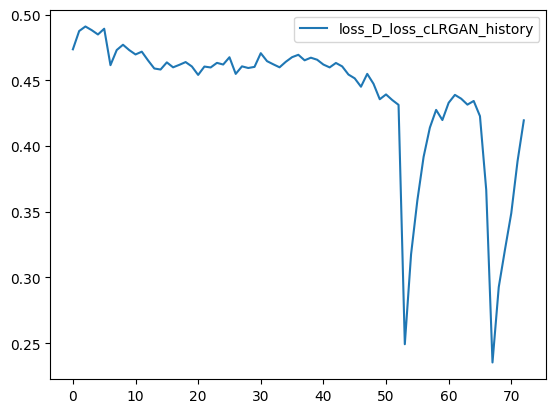

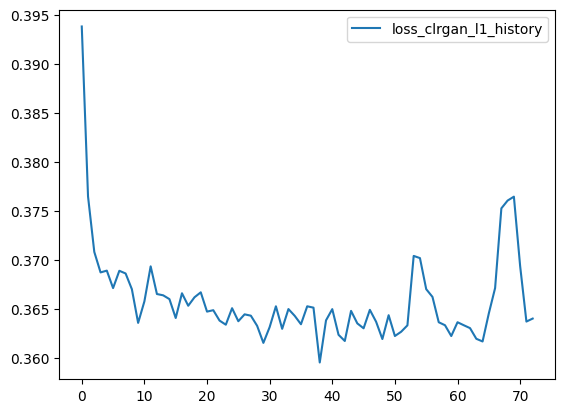

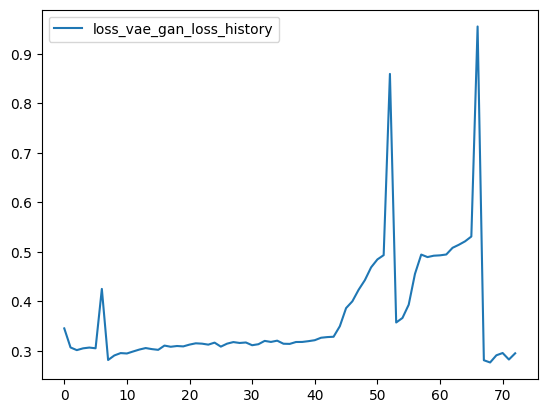

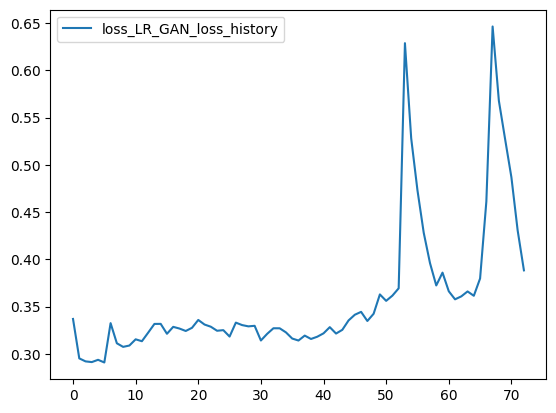

As we see from above plots specifically total loss plots, our training has been smooth for most of the parts except the last 1-2 epochs. This is where we faced mode collapse as well as shown in the visualization given below. This is why we stopped training after 12 epochs. But we feel looking at the plots as well, we were able to reduce total loss well

### Showing intermediate visualization

**Epoch1**

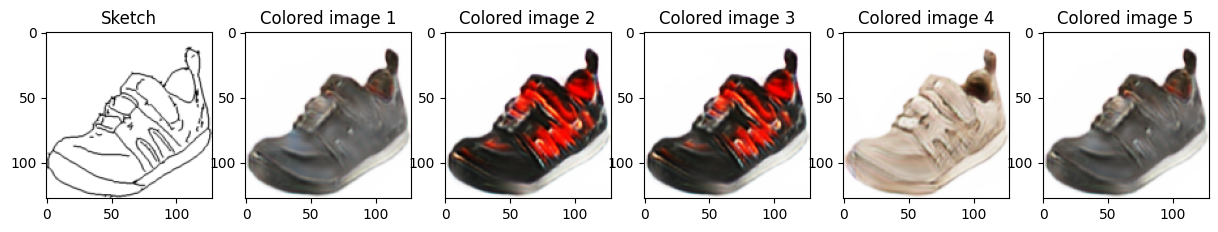

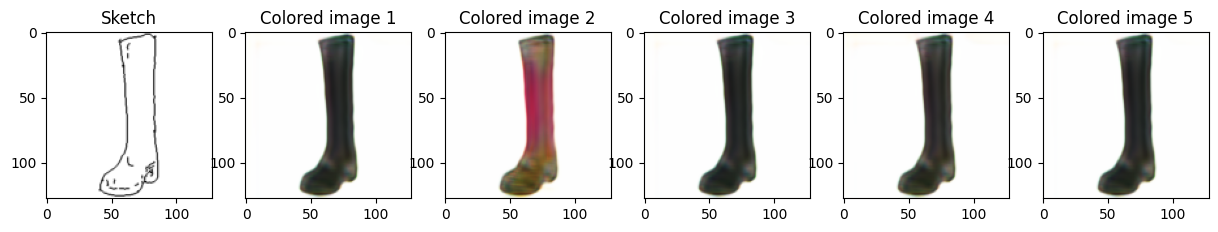

Epoch2

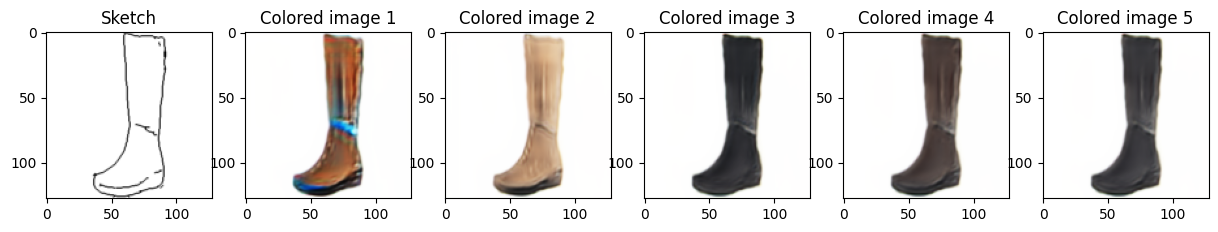

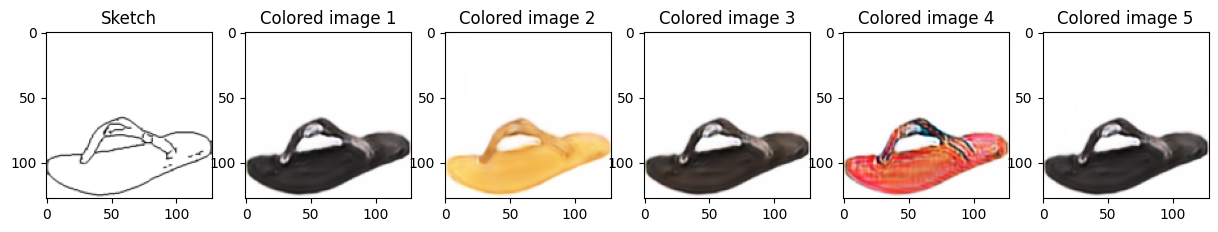

**Epoch3**

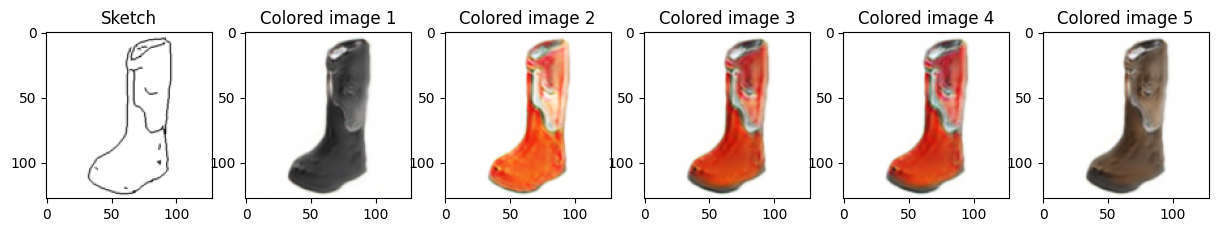

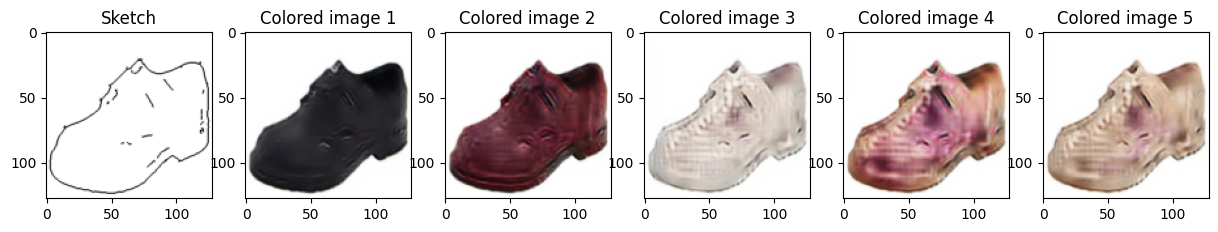

**Epoch4**

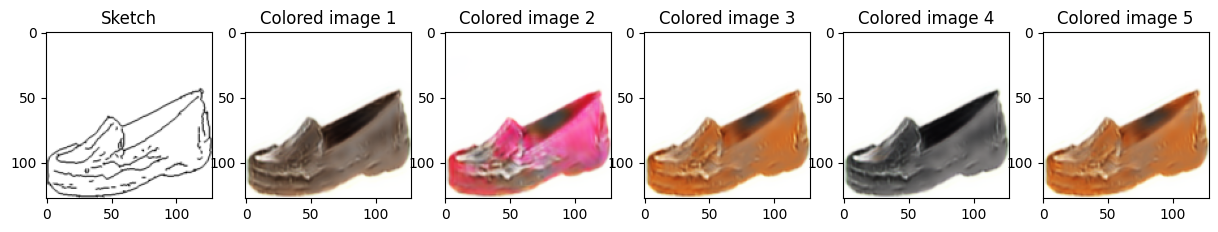

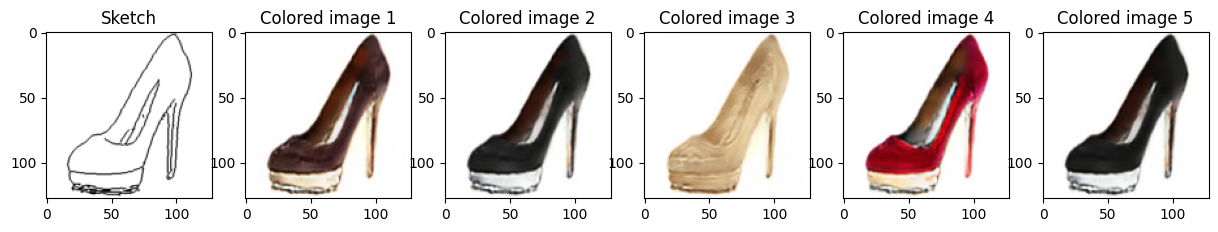

**Epoch 5**

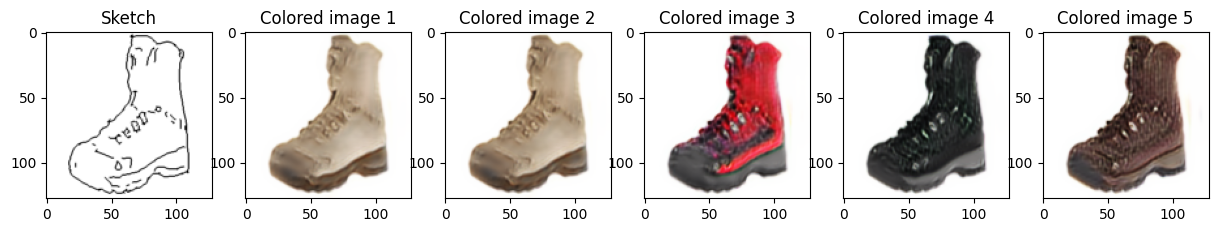

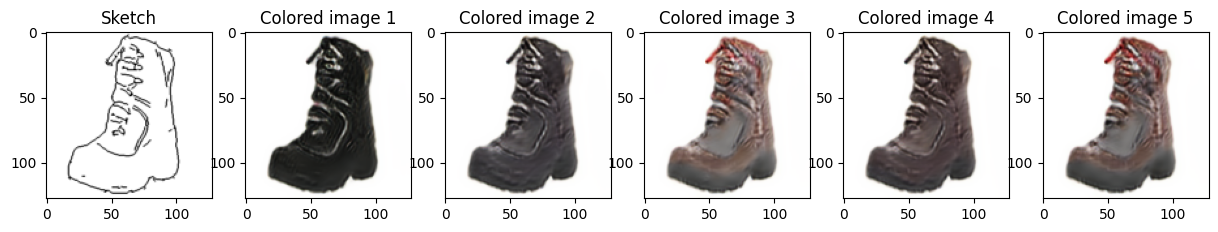

**Epoch 6**

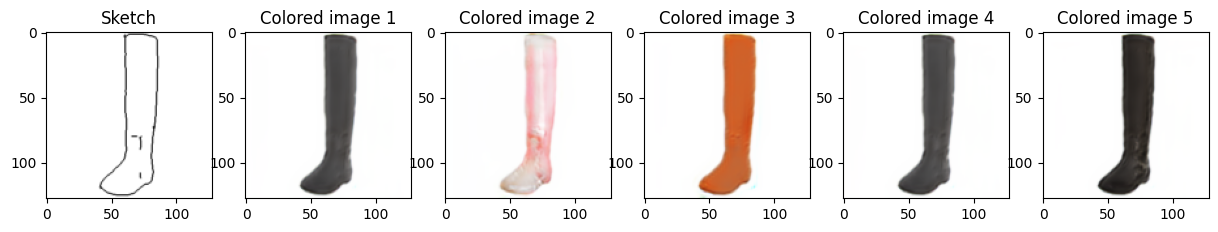

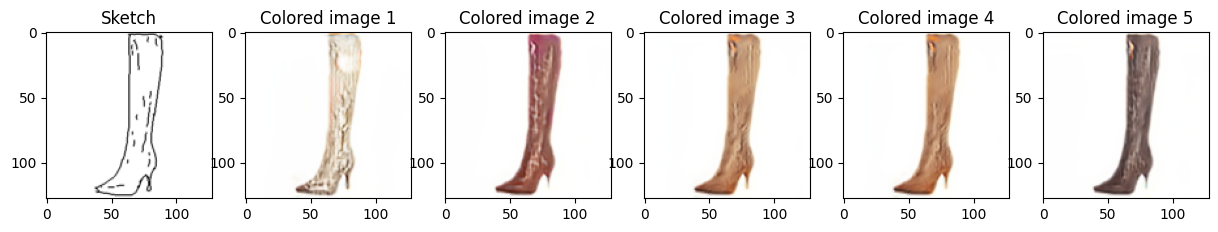

**Epoch 7**

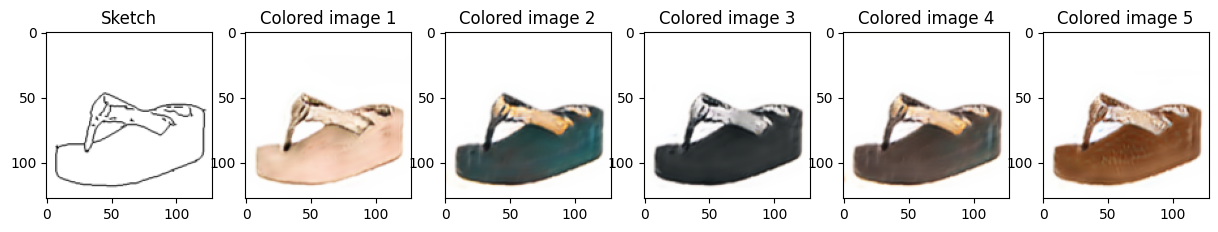

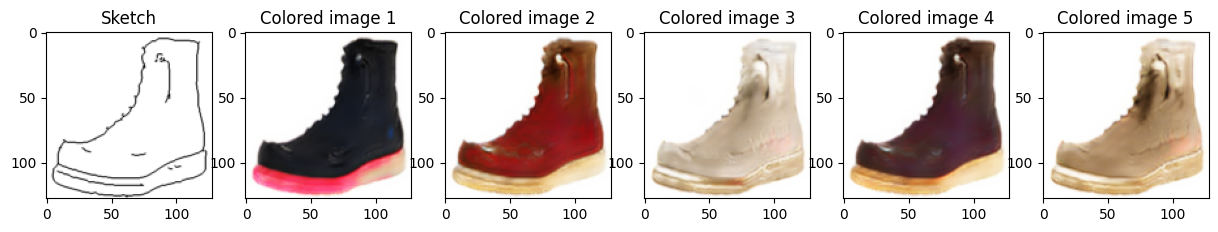

**Epoch 8**

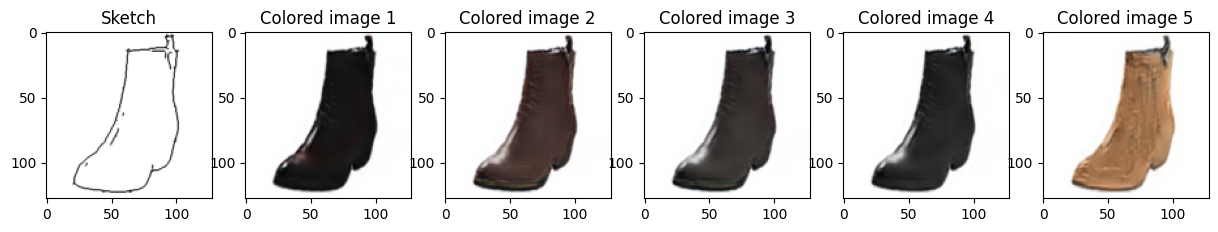

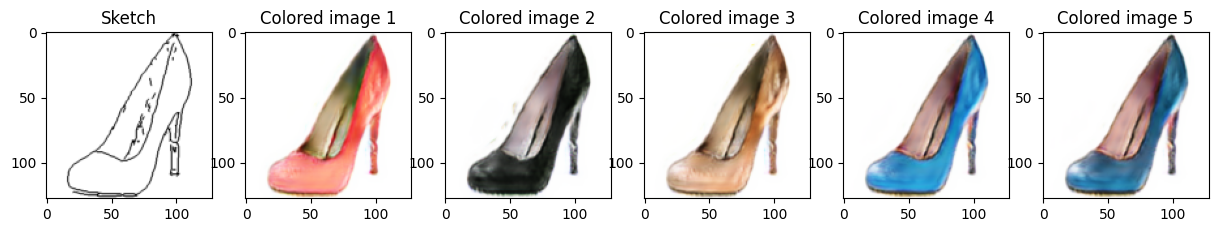

**Epoch 9**

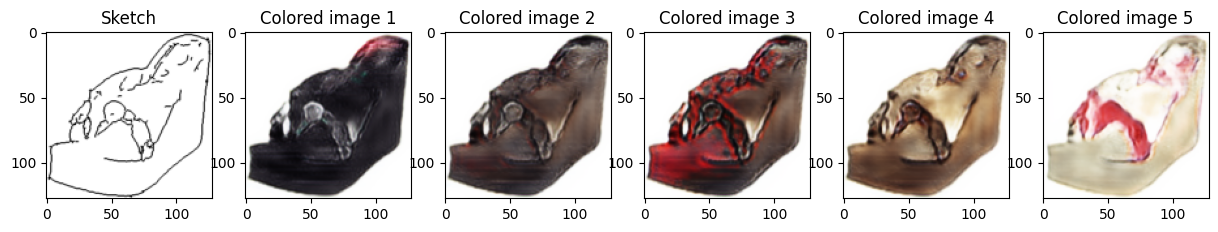

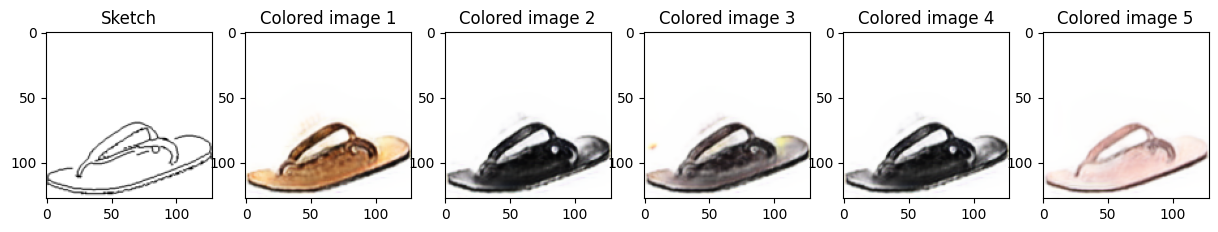

**Epoch 10**

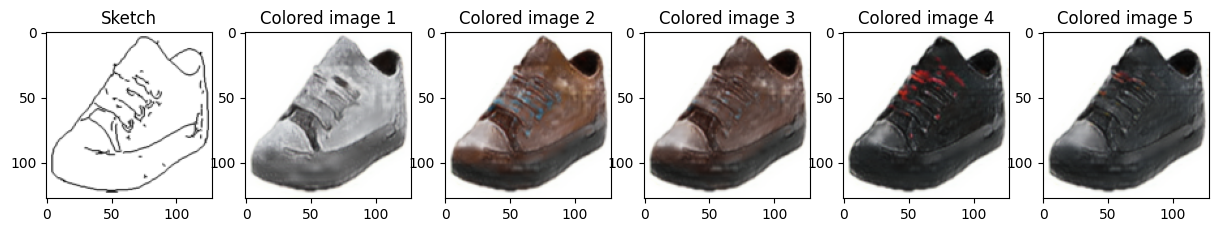

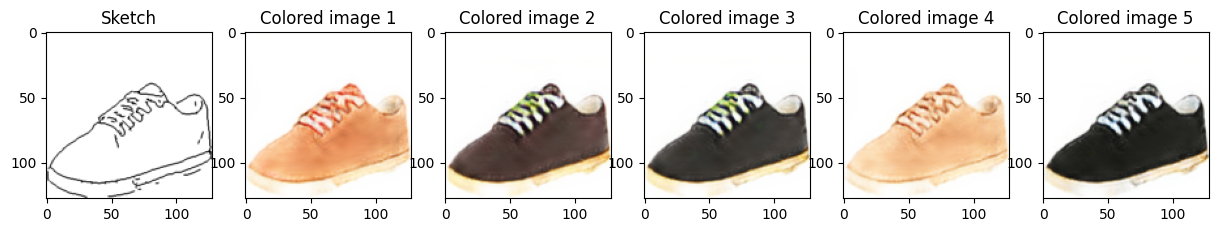

**Epoch 11**

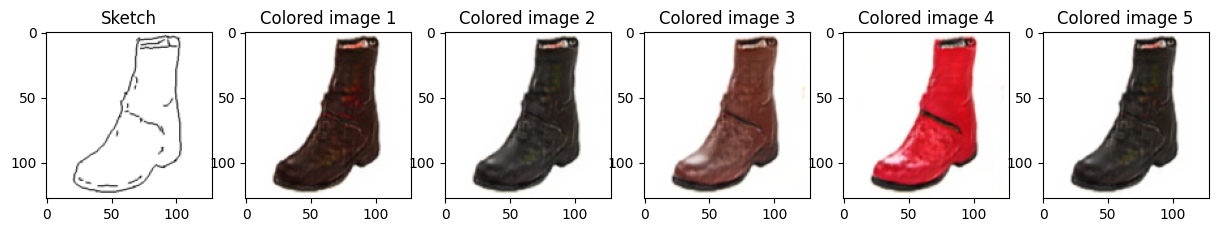

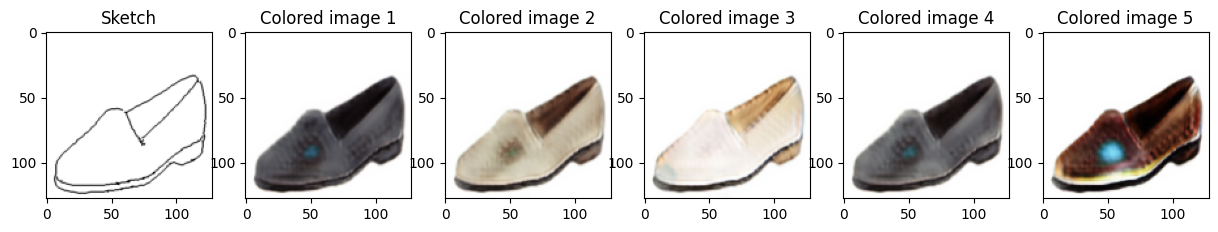

**Epoch 12**

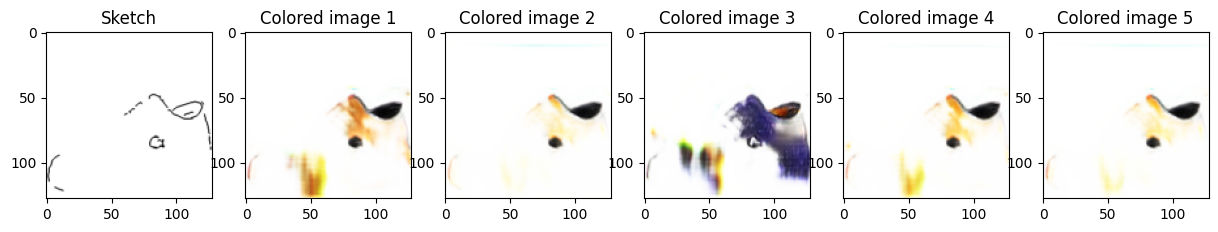

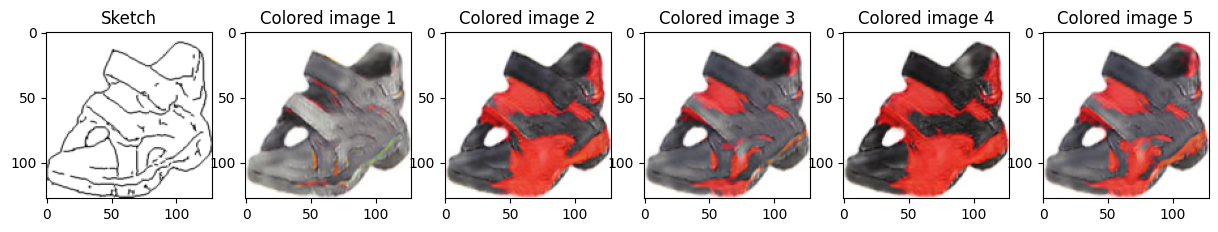

### As seen from above visualizaions, our model has impproved in producing diverse outputs over epochs. But we also note that after 11 epochs, we seemed to have hit a mode collapse and that's why we decided to stop training after 12 epochs

# Loading model checkpoint

# Upload checkpoint file

In [ ]:
generator = Generator(latent_dim, img_shape, n_residual_blocks, device=gpu_id).to(gpu_id)
encoder = Encoder(latent_dim).to(gpu_id)
D_VAE = Discriminator().to(gpu_id)
D_LR = Discriminator().to(gpu_id)

# Define optimizers for networks
optimizer_E = torch.optim.Adam(encoder.parameters(), lr=lr_rate, betas=betas)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_rate, betas=betas)
optimizer_D_VAE = torch.optim.Adam(D_VAE.parameters(), lr=lr_rate, betas=betas)
optimizer_D_LR = torch.optim.Adam(D_LR.parameters(), lr=lr_rate, betas=betas)

# Loading model
filename = f'checkpoint_epoch{12}_step_{80976}.pt'
path_to_checkpoint = os.path.join('/content/checkpoint_epoch12_step_80976.pt')
ckt = torch.load(path_to_checkpoint)
#load losses
total_loss_history = ckt['loss_total']
#print("checkpointed total loss history : ",total_loss_history)
loss_cvaegan_l1_history = ckt['cvaegan_l1']
loss_KLD_history = ckt['KLD']
loss_D_loss_cVAE_history = ckt['D_loss_cVAE']
loss_D_loss_cLRGAN_history =ckt['D_loss_cLRGAN']
loss_clrgan_l1_history = ckt['clrgan_l1']
loss_vae_gan_loss_history = ckt['VAE_GAN_loss']
loss_LR_GAN_loss_history = ckt['LR_GAN_loss']
#load gen,disc,encoder objects
generator.load_state_dict(ckt['generator'])
encoder.load_state_dict(ckt['encoder'])
D_VAE.load_state_dict(ckt['D_VAE'])
D_LR.load_state_dict(ckt['D_LR'])
#load optimizers
optimizer_G.load_state_dict(ckt['optimizer_G'])
optimizer_E.load_state_dict(ckt['optimizer_E'])
optimizer_D_VAE.load_state_dict(ckt['optimizer_D_VAE'])
optimizer_D_LR.load_state_dict(ckt['optimizer_D_LR'])

# Generator Visualization

In [ ]:
test_img_dir = '/content/train/'
test_dataset = Edge2Shoe(test_img_dir)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle = False)

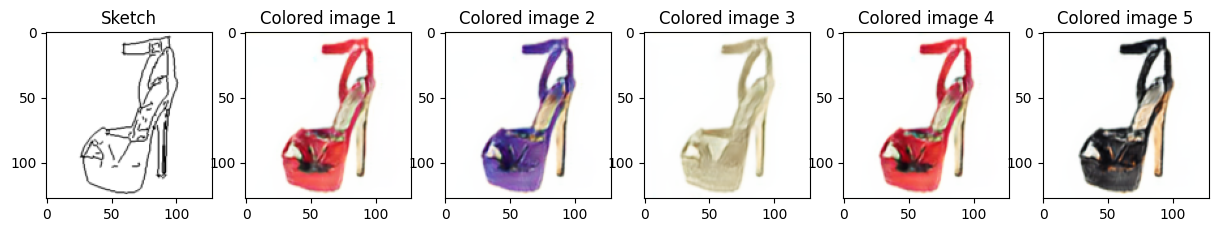

In [ ]:
# Sample a batch
samples = []
for data in test_loader:
    sketch,colored = data
    break

sketch = norm(sketch).to(gpu_id)
# Pass through generator
plot_sketch_to_multimodal(generator,sketch[1],8)

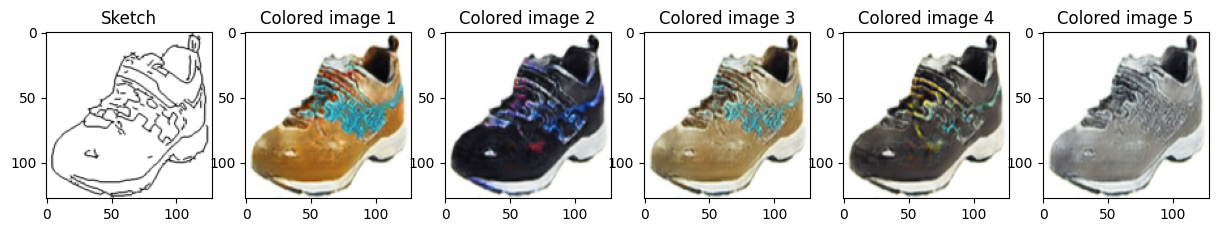

In [ ]:
plot_sketch_to_multimodal(generator,sketch[4],8)

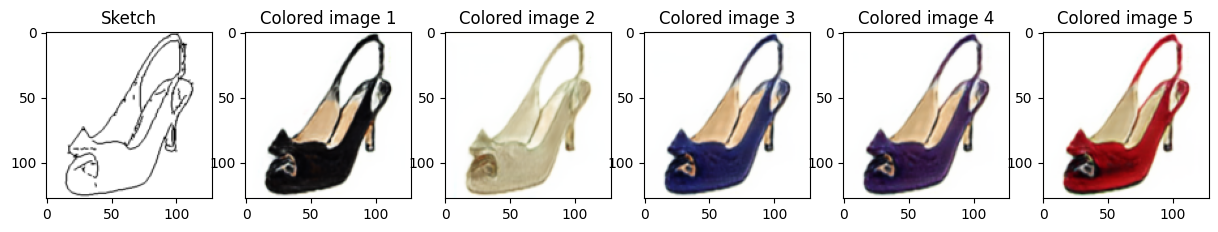

In [ ]:
plot_sketch_to_multimodal(generator,sketch[6],8)

# Model evaluation on test set images

We create three folders real1 and real2 and fake1. We divide whole test images in two halves.

* If a real image comes from first half, we store it in real1 folder -> generate fake images -> store in fake1.

* If a real image comes from 2nd half, we store it in real2 folder. We dont compute fake images.

Next we compute FID bw
* real1 and fake1
* real1 and real2

In [ ]:
test_img_dir = '/content/val/'
real1_test_images_dir = '/content/real1'
real2_test_images_dir = '/content/real2'
fake_test_images_dir = '/content/fake'

os.makedirs(real1_test_images_dir, exist_ok=True)
os.makedirs(real2_test_images_dir, exist_ok=True)
os.makedirs(fake_test_images_dir, exist_ok=True)


# Define DataLoader
test_dataset = Edge2Shoe(test_img_dir)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle = False)
tqdm_test_loader = tqdm(test_loader, total=len(test_loader))

half_dataset_size = len(test_dataset) // 2

generator.eval()
with torch.no_grad():
  for idx, (edge_tensor, rgb_tensor) in enumerate(tqdm(test_loader, total=len(test_loader))):
      edge_tensor, rgb_tensor = norm(edge_tensor).to(gpu_id), norm(rgb_tensor).to(gpu_id)
      real_A = edge_tensor
      real_B = rgb_tensor

      # Save real images in two different folders
      if idx < half_dataset_size // batch_size:
          for i, real_img in enumerate(real_B):
              save_path = os.path.join(real1_test_images_dir, f'real_img_{idx}_{i}.png')
              real_img_denorm = denorm(real_img).type(torch.FloatTensor) / 255.0
              save_image(real_img_denorm, save_path)

              # Generate and save one fake image for each real sketch in the first half
              z_random = torch.randn(1, latent_dim).to(gpu_id)
              fake_img = generator(real_A[i:i+1], z_random)
              save_path_fake = os.path.join(fake_test_images_dir, f'fake_img_{idx}_{i}.png')
              fake_img_denorm = denorm(fake_img.squeeze(0)).type(torch.FloatTensor) / 255.0
              save_image(fake_img_denorm, save_path_fake)

      else:
        for i, real_img in enumerate(real_B):
          save_path = os.path.join(real2_test_images_dir, f'real_img_{idx}_{i}.png')
          real_img_denorm = denorm(real_img).type(torch.FloatTensor) / 255.0
          save_image(real_img_denorm, save_path)


100%|██████████| 25/25 [00:02<00:00,  8.41it/s]


# FID Score computation

In [ ]:
print('computing FID score between real rgb2 and real rgb1')
! python -m pytorch_fid '/content/real2' '/content/real1'

print('computing FID score between real rgb2 and fake rgb1')
! python -m pytorch_fid '/content/real2' '/content/fake'


computing FID score between real rgb2 and real rgb1
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 158MB/s]
100% 3/3 [00:01<00:00,  2.04it/s]
100% 2/2 [00:00<00:00,  3.03it/s]
FID:  61.86513809572699
computing FID score between real rgb2 and fake rgb1
100% 3/3 [00:00<00:00,  3.30it/s]
100% 2/2 [00:00<00:00,  3.80it/s]
FID:  103.50226138941747


# Results -
* Higher FID between real rgb1 and real rgb2 means dataset is diverse enough.
* FID of 103.5 between real rgb2 and fake1 means that model has performed good but is not the best in getting a distribution close to real images distribution

FID score told us how close is the distribution of generated images to real images. Next we try Inception score that tells how is the quality, diversity of generated images

#  Computing Inception score (IS Score)


Upload inception py file

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle = False)

real_images_dir = '/content/real_images/'
fake_images_dir = '/content/fake_images/'
os.makedirs(real_images_dir, exist_ok=True)
os.makedirs(fake_images_dir, exist_ok=True)

# Lists to store generated and real images
fake_images = []
real_images = []

generator.eval()
with torch.no_grad():
    for idx, (edge_tensor, rgb_tensor) in enumerate(tqdm(test_loader, total=len(test_loader))):
        edge_tensor, rgb_tensor = norm(edge_tensor).to(gpu_id), norm(rgb_tensor).to(gpu_id)
        real_A = edge_tensor
        real_B = rgb_tensor

        for i in range(real_B.size(0)):  # Iterate through each image in the batch
            real_img = real_B[i]
            real_images.append(denorm(real_img.detach()))

            save_path = os.path.join(real_images_dir, f'real_img_{idx}_{i}.png')
            real_img_denorm = denorm(real_img).type(torch.FloatTensor) / 255.0
            save_image(real_img_denorm, save_path)

            # Handle fake images
            z_random = torch.randn(1, latent_dim).to(gpu_id)
            fake_img = generator(real_A[i:i+1], z_random)  # Generate fake image for the ith real image
            fake_img = fake_img.squeeze(0)
            fake_images.append(denorm(fake_img.detach()))
            save_path_fake = os.path.join(fake_images_dir, f'fake_img_{idx}_{i}.png')
            fake_img_denorm = denorm(fake_img.squeeze(0)).type(torch.FloatTensor) / 255.0
            save_image(fake_img_denorm, save_path_fake)

# Concatenate generated and real images into tensors
fake_images_tensor = torch.stack(fake_images)
real_images_tensor = torch.stack(real_images)

# Create TensorDatasets for each dataset
fake_images_dataset = TensorDataset(fake_images_tensor)
real_images_dataset = TensorDataset(real_images_tensor)




100%|██████████| 25/25 [00:05<00:00,  4.44it/s]


In [ ]:
from inception_score import inception_score

print('IS score for real test images data set:')
print(inception_score(real_images_dataset, cuda=True, batch_size=8, resize=False, splits=10))

print('IS score for generated test images data set:')
print(inception_score(fake_images_dataset, cuda=True, batch_size=8, resize=False, splits=10))


IS score for real test images data set:
(5.794024456334639, 1.6517965637082157)
IS score for generated test images data set:
(6.185642715494946, 0.9396945222731139)


# Results -
* We see that IS score for real images is 5.79 and for test images is 6.18 .
* A higher IS score means that the images are of high quality and are diverse.
* This result shows that our generator has performed well in generating diverse and high quality images

# LPIPS Score for diversity

Create a folder for sketches

In [ ]:
test_img_dir = '/content/val/'
sketch_dir = '/content/sketches'
os.makedirs(sketch_dir, exist_ok=True)

# Define DataLoader
test_dataset = Edge2Shoe(test_img_dir)  # Ensure Edge2Shoe is defined or imported correctly
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
tqdm_test_loader = tqdm(test_loader, total=len(test_loader))


generator.eval()
with torch.no_grad():
    for idx, (edge_tensor, _) in enumerate(tqdm_test_loader):
        # Normalize and send to GPU if needed
        edge_tensor = norm(edge_tensor).to(gpu_id)

        # Save the edge tensor as an image in the sketch folder
        save_image(edge_tensor, os.path.join(sketch_dir, f'sketch_{idx}.png'))

100%|██████████| 200/200 [00:00<00:00, 205.75it/s]


In [ ]:
!pip install lpips
import lpips


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.8 MB/s eta 0:00:00


In [ ]:
lpips_model = lpips.LPIPS(net='alex').to(gpu_id)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth

  0%|          | 0.00/233M [00:00<?, ?B/s]
  3%|▎         | 7.61M/233M [00:00<00:02, 79.5MB/s]
  7%|▋         | 15.2M/233M [00:00<00:02, 79.0MB/s]
 14%|█▎        | 31.6M/233M [00:00<00:01, 121MB/s] 
 20%|██        | 47.1M/233M [00:00<00:01, 137MB/s]
 26%|██▌       | 60.2M/233M [00:00<00:01, 135MB/s]
 31%|███▏      | 73.1M/233M [00:00<00:01, 132MB/s]
 37%|███▋      | 85.8M/233M [00:00<00:01, 120MB/s]
 42%|████▏     | 97.4M/233M [00:00<00:01, 115MB/s]
 47%|████▋     | 109M/233M [00:01<00:01, 95.7MB/s]
 51%|█████     | 118M/233M [00:01<00:01, 95.9MB/s]
 55%|█████▍    | 128M/233M [00:01<00:01, 94.0MB/s]
 59%|█████▊    | 137M/233M [00:01<00:01, 88.6MB/s]
 62%|██████▏   | 146M/233M [00:01<00:01, 86.2MB/s]
 66%|██████▋   | 155M/233M [00:01<00:00, 89.5MB/s]
 70%|███████   | 164M/233M [00:01<00:00, 89.5MB/s]
 74%|███████▍  | 173M/233M [00:01<00:00, 91.5MB/s

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
def compute_lpips(generator, sketch, z_dim, n=10):
    sketches = sketch.repeat(n, 1, 1, 1)
    z_random = torch.randn(n, z_dim).to(gpu_id)
    out = generator(sketches, z_random)

    # Calculate LPIPS scores
    lpips_scores = []
    for i in range(n):
        for j in range(i+1, n):
            score = lpips_model(out[i:i+1], out[j:j+1])
            lpips_scores.append(score.item())

    # Calculate average LPIPS score
    avg_lpips_score = sum(lpips_scores) / len(lpips_scores)
    #print(f"Average LPIPS score: {avg_lpips_score}")

    return avg_lpips_score




Trying above function for 1st sketch

In [ ]:
from torchvision import transforms

first_sketch_path = os.path.join(sketch_dir, 'sketch_0.png')

sketch = Image.open(first_sketch_path).convert('RGB')
transform = transforms.Compose([
    transforms.ToTensor()])
sketch_tensor = transform(sketch).unsqueeze(0).to(gpu_id)
avg_lpips_score = compute_lpips(generator, sketch_tensor, 8, n=5)
print("LPIPS image score for one sketch: ", avg_lpips_score)

LPIPS image score for one sketch:  0.1890645525418222


Calculating LPIPS score for 200 val images

In [ ]:
val_lpips_sum = 0
c = 0
for sketch_file in tqdm(sorted(os.listdir(sketch_dir))):
  sketch_path = os.path.join(sketch_dir, sketch_file)
  # Load and transform the sketch
  sketch = Image.open(sketch_path).convert('RGB')
  sketch_tensor = transform(sketch).unsqueeze(0).to(gpu_id)
  avg_lpips_score = compute_lpips(generator, sketch_tensor, 8, n=5)
  val_lpips_sum += avg_lpips_score
  c += 1






100%|██████████| 200/200 [00:11<00:00, 17.92it/s]


In [ ]:
print("Final LPIPS Score for validation set: ",val_lpips_sum/c )


Final LPIPS Score for validation set:  0.15139397340165303


### As shown above, the average LPIPS score over 200 images = 0.151

## Novelty: Using CLIP to guide image generation

In [ ]:
!git clone https://github.com/openai/CLIP.git
!pip install -r CLIP/requirements.txt

Cloning into 'CLIP'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 251 (delta 3), reused 3 (delta 0), pack-reused 243
Receiving objects: 100% (251/251), 8.93 MiB | 23.68 MiB/s, done.
Resolving deltas: 100% (127/127), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 935.9 kB/s eta 0:00:00


In [ ]:
%cd CLIP
import clip


/content/CLIP


In [ ]:
model, preprocess = clip.load("ViT-B/32", device=device)


  0%|                                               | 0.00/338M [00:00<?, ?iB/s]
  3%|█▏                                     | 10.2M/338M [00:00<00:03, 107MiB/s]
 10%|███▊                                   | 33.0M/338M [00:00<00:01, 185MiB/s]
 16%|██████▎                                | 54.2M/338M [00:00<00:01, 200MiB/s]
 22%|████████▊                              | 75.9M/338M [00:00<00:01, 211MiB/s]
 29%|███████████▎                           | 97.7M/338M [00:00<00:01, 217MiB/s]
 35%|██████████████                          | 118M/338M [00:00<00:01, 209MiB/s]
 41%|████████████████▍                       | 138M/338M [00:00<00:01, 195MiB/s]
 47%|██████████████████▌                     | 157M/338M [00:00<00:01, 184MiB/s]
 52%|████████████████████▋                   | 175M/338M [00:00<00:00, 175MiB/s]
 57%|██████████████████████▋                 | 192M/338M [00:01<00:00, 167MiB/s]
 62%|████████████████████████▉               | 210M/338M [00:01<00:00, 175MiB/s]
 69%|██████████████████████

In [ ]:
ckt_path = '/content/checkpoint_epoch12_step_80976.pt'
generator = Generator(latent_dim, img_shape, n_residual_blocks, device=gpu_id).to(gpu_id)
ckt = torch.load(ckt_path)

generator.load_state_dict(ckt['generator'])

<All keys matched successfully>

# 1.Getting Similar images via sampling

In [ ]:
def tensor_to_pil_img(img):
    img = img.permute(1,2,0).detach().cpu().numpy()
    img = Image.fromarray(img.astype('uint8'))
    return img

def find_matching_images_CLIP(generator,sketch,text_string,z_dim = 8,n_samples=10,n_return=3):

    sketch = norm(sketch).to(gpu_id)

    sketches = sketch[0].repeat(n_samples,1,1,1).to(gpu_id)
    z_random = torch.randn(n_samples,z_dim).to(gpu_id)

    #print(z_random)
    out = generator(sketches,z_random)


    text = clip.tokenize([text_string]).to(device)


    images = [(torch.permute(denorm(out[i].squeeze()),(1,2,0)).cpu().data.numpy().astype(np.uint8)) for i in range(out.shape[0])]
    images = [preprocess(Image.fromarray(img.astype('uint8'))).unsqueeze(0).to(device) for img in images]

    with torch.no_grad():
            scores = [model(image,text)[0] for image in images]


    top_indices = np.argpartition(scores, -n_return)[-n_return:]

    res_images,res_scores = ([images[i] for i in top_indices],[scores[i] for i in top_indices])
    top_indices = np.argpartition(scores, -n_return)[-n_return:]

    return images[top_indices], scores[top_indices]

In [ ]:
dataset = Edge2Shoe("/content/train/")
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle = False)

In [ ]:
for data in loader:
    sketch,colored = data
    break

sketch = norm(sketch).to(gpu_id)

In [ ]:
n_samples = 10
z_dim = 8
n_return = 2


sketches = sketch[0].repeat(n_samples,1,1,1).to(gpu_id)
z_random = torch.randn(n_samples,z_dim).to(gpu_id)

#print(z_random)
out = generator(sketches,z_random)


In [ ]:
sketch = norm(sketch).to(gpu_id)
text = clip.tokenize(["White Shoe"]).to(device)


images = [(torch.permute(denorm(out[i].squeeze()),(1,2,0)).cpu().data.numpy().astype(np.uint8)) for i in range(out.shape[0])]
images = [preprocess(Image.fromarray(img.astype('uint8'))).unsqueeze(0).to(device) for img in images]

with torch.no_grad():
        scores = [model(image,text)[0][0][0].detach().cpu().numpy() for image in images]

top_indices = np.argpartition(scores, -n_return)[-n_return:]

res_images,res_scores = ([images[i] for i in top_indices],[scores[i] for i in top_indices])

## Displaying search space of n outputs for CLIP similarity for a given sketch

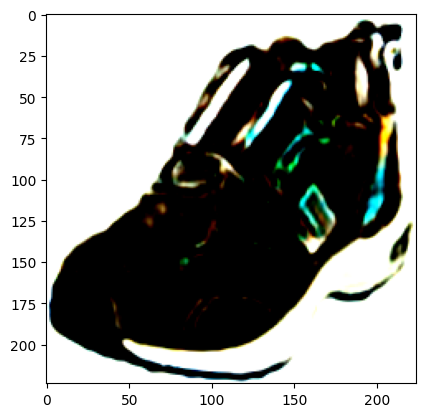

[[20.16]]


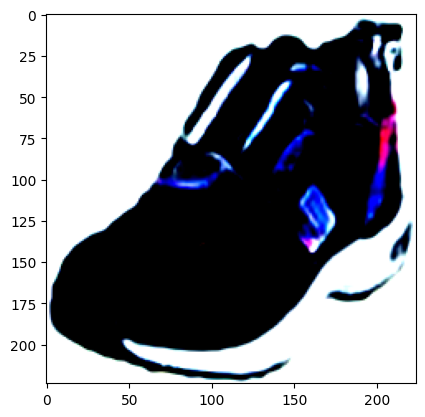

[[22.84]]


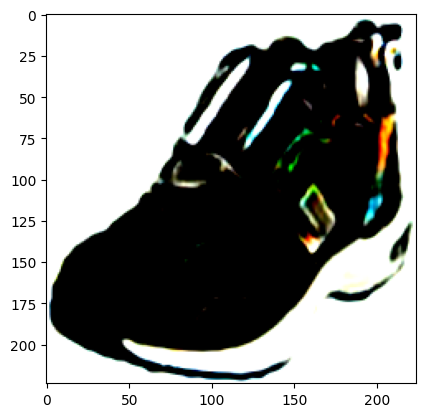

[[22.48]]


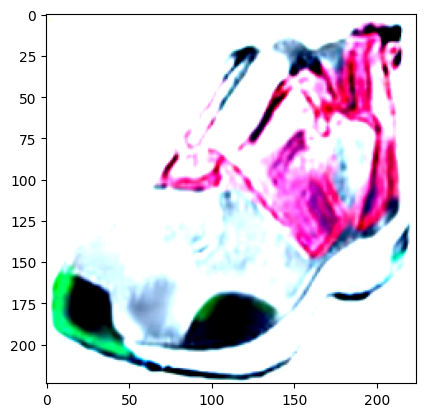

[[24.03]]


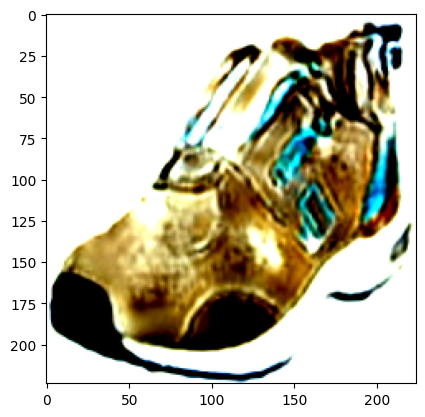

[[22.56]]


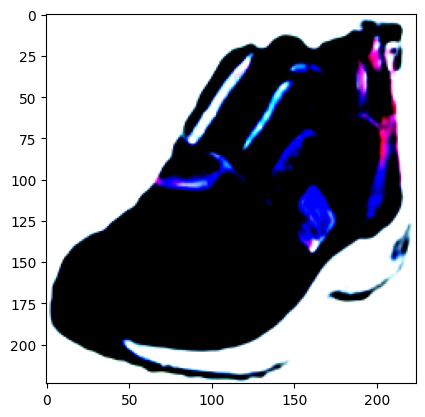

[[22.61]]


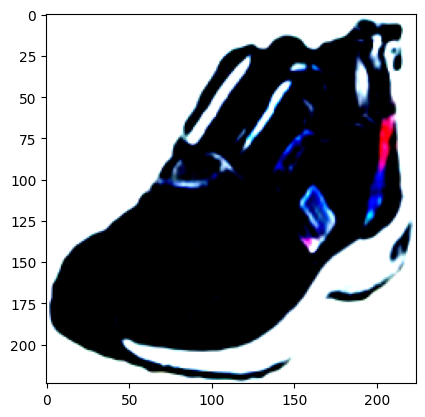

[[23.]]


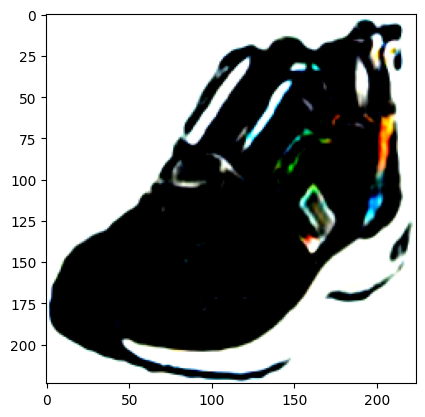

[[22.39]]


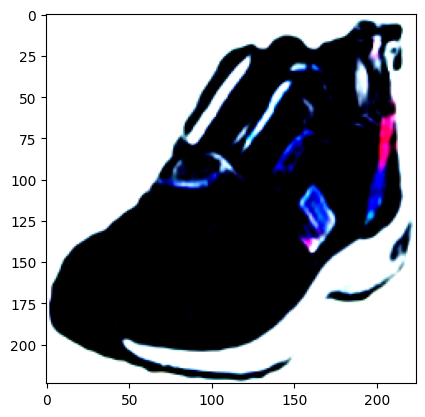

[[22.62]]


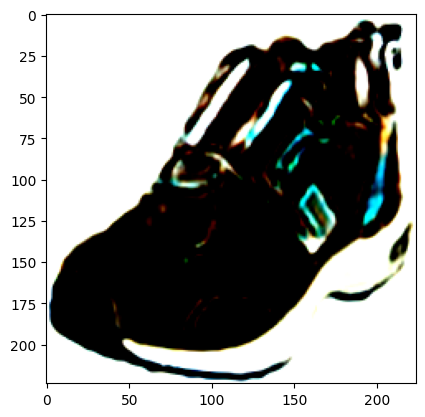

[[20.16]]


In [ ]:
for i in range(len(images)):
    plt.imshow(torch.permute(images[i].squeeze(),(1,2,0)).detach().cpu().numpy())
    plt.show()
    print(scores[i])

## Displaying top_n images matching text prompt

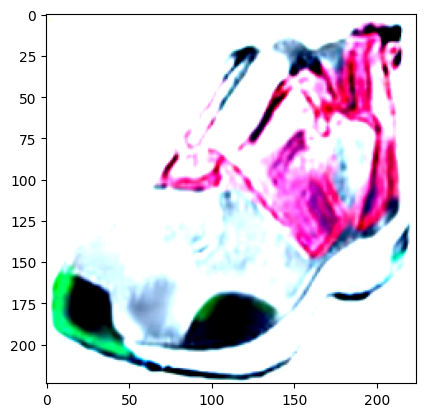

24.03


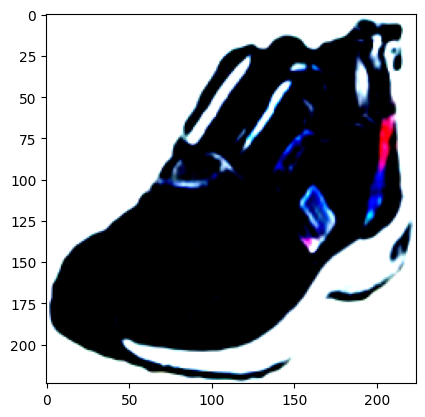

23.0


In [ ]:
%matplotlib inline
for i in range(len(res_images)-1,-1,-1):
    plt.imshow(torch.permute(res_images[i].squeeze(),(1,2,0)).detach().cpu().numpy())
    plt.show()
    print(res_scores[i])

**The shoe which matches the text prompt "White Shoe" most is displayed first**

# 2.Getting text-matching images via gradient descent in latent space

In the below cell we start off with a random latent and try to get an output matching our given text prompt: "Black Shoe"

USING  cuda
Step 0
Loss 3.537109375
Step 5
Loss 3.44140625
Step 10
Loss 3.41796875
Step 15
Loss 3.408203125
Step 20
Loss 3.408203125
Step 25
Loss 3.408203125
Step 30
Loss 3.40625
Step 35
Loss 3.40625
Step 40
Loss 3.40625
Step 45
Loss 3.40625
Step 50
Loss 3.40625
Step 55
Loss 3.40625
Step 60
Loss 3.40234375
Step 65
Loss 3.40234375
Step 70
Loss 3.40234375
Step 75
Loss 3.40625
Step 80
Loss 3.40234375
Step 85
Loss 3.40234375
Step 90
Loss 3.40234375
Step 95
Loss 3.40234375
Step 100
Loss 3.400390625
Step 105
Loss 3.40625
Step 110
Loss 3.40234375
Step 115
Loss 3.40234375
Step 120
Loss 3.40625
Step 125
Loss 3.40234375
Step 130
Loss 3.400390625
Step 135
Loss 3.400390625
Step 140
Loss 3.400390625
Step 145
Loss 3.40234375
Step 150
Loss 3.40234375
Step 155
Loss 3.400390625
Step 160
Loss 3.40234375
Step 165
Loss 3.40625
Step 170
Loss 3.40625
Step 175
Loss 3.400390625
Step 180
Loss 3.40234375
Step 185
Loss 3.40625
Step 190
Loss 3.400390625
Step 195
Loss 3.400390625
Step 200
Loss 3.40234375
Step 205


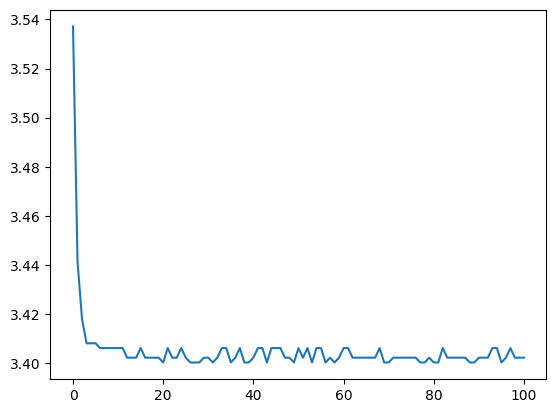

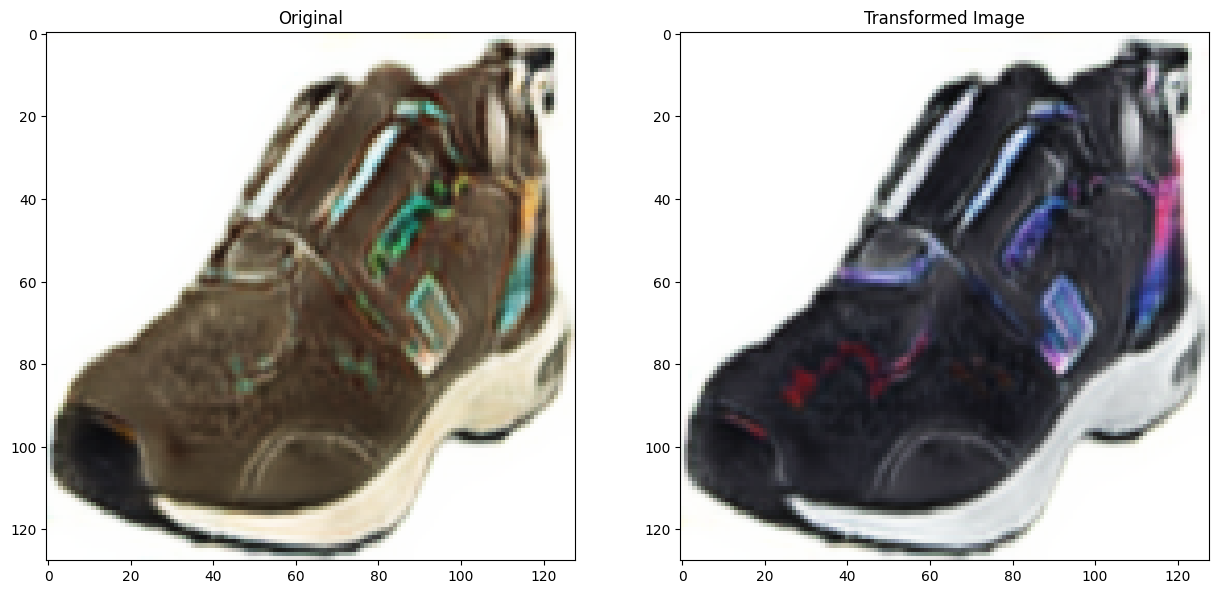

In [ ]:
%matplotlib inline
import shutil
import torchvision



#torch.manual_seed(20)
z_dim = 8


batch_size = 8
lr = 1e-1
img_save_freq = 5

text = "Black Shoe"

output_dir = "/content/CLIP_results_dict"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("USING ", device)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)


generator.eval()
generator.to(device)


latent_shape = (1, z_dim)

latents_init = torch.randn(latent_shape).squeeze(-1).to(device) #inits a latent vector, upon which we perform gradient descent(let's draw from normal dist for ours)
latents = torch.nn.Parameter(latents_init, requires_grad=True)
optimizer = torch.optim.Adam(
    params=[latents],
    lr=lr,
    betas=(0.9, 0.999),
)


def tensor_to_pil_img(img):
    img = (img.clamp(-1, 1) + 1) / 2.0
    img = img[0].permute(1, 2, 0).detach().cpu().numpy() * 255
    img = Image.fromarray(img.astype('uint8'))
    return img


clip_transform = torchvision.transforms.Compose([
    clip_preprocess.transforms[4],
])

ref_img_path = None

if ref_img_path is None:
    dataset = Edge2Shoe("/content/train/")
    loader = torch.utils.data.DataLoader(dataset, batch_size=8)
    for data in loader:
        sketch,colored = data
        break
    sketch = norm(sketch).to(gpu_id)

else:
    raise Exception("Not defined")

clip_normalize = torchvision.transforms.Normalize(
    mean=(0.48145466, 0.4578275, 0.40821073),
    std=(0.26862954, 0.26130258, 0.27577711),
)

def compute_clip_loss(img, text):
    img = clip_transform(img)
    img = torch.nn.functional.upsample_bilinear(img, (224, 224)) #resize since clip original resize non differentiable
    tokenized_text = clip.tokenize([text]).to(device)
    img_logits, _text_logits = clip_model(img, tokenized_text)

    return 1/img_logits * 100

counter = 0


try:
    shutil.rmtree("/content/CLIP_results_dict")
except Exception as e:
    print("exception",e)
    pass

os.mkdir("/content/CLIP_results_dict")

loss_list = []
while True:
    sketches = sketch[0].repeat(1,1,1,1).to(gpu_id)
    out = generator(sketches,latents)
    loss = compute_clip_loss(out,text)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if counter % img_save_freq == 0:
        img = tensor_to_pil_img(out)
        img.save(os.path.join(output_dir, f'{counter}.png'))

        print(f'Step {counter}')
        print(f'Loss {loss.data.cpu().numpy()[0][0]}')
        loss_list.append(loss.data.cpu().numpy()[0][0])
    counter += 1
    if counter >= 501:
        break

plt.plot(loss_list)
plt.show()

img0 = Image.open(os.path.join('/content/CLIP_results_dict','0.png'))
img500 = Image.open(os.path.join('/content/CLIP_results_dict','500.png'))

fig, axs = plt.subplots(1,2, figsize = (15,30
                                            ))
axs[0].imshow(img0)
axs[0].set_title('Original')

axs[1].imshow(img500)
axs[1].set_title('Transformed Image')

plt.show()


**Using the starting point of a latent corresponding to a brown shoe, we have backpropagated using CLIP logits to transform it into a latent which gives a black shoe, matching the text prompt!**

Below our prompt is "Red Shoe"

USING  cuda



  1%|          | 3/501 [00:00<00:44, 11.22it/s]

Step 0
Loss 3.82421875



  1%|▏         | 7/501 [00:00<00:41, 12.00it/s]

Step 5
Loss 3.265625



  3%|▎         | 13/501 [00:01<00:37, 12.89it/s]

Step 10
Loss 3.314453125



  3%|▎         | 17/501 [00:01<00:36, 13.14it/s]

Step 15
Loss 3.32421875



  5%|▍         | 23/501 [00:01<00:35, 13.56it/s]

Step 20
Loss 3.31640625



  5%|▌         | 27/501 [00:02<00:35, 13.44it/s]

Step 25
Loss 3.30859375



  7%|▋         | 33/501 [00:02<00:36, 12.97it/s]

Step 30
Loss 3.302734375



  7%|▋         | 37/501 [00:02<00:34, 13.33it/s]

Step 35
Loss 3.267578125



  9%|▊         | 43/501 [00:03<00:34, 13.40it/s]

Step 40
Loss 3.240234375



  9%|▉         | 47/501 [00:03<00:34, 13.24it/s]

Step 45
Loss 3.259765625



 11%|█         | 53/501 [00:04<00:33, 13.21it/s]

Step 50
Loss 3.23828125



 11%|█▏        | 57/501 [00:04<00:33, 13.42it/s]

Step 55
Loss 3.234375



 13%|█▎        | 63/501 [00:04<00:32, 13.41it/s]

Step 60
Loss 3.23828125



 13%|█▎        | 67/501 [00:05<00:38, 11.15it/s]

Step 65
Loss 3.228515625



 15%|█▍        | 73/501 [00:05<00:39, 10.73it/s]

Step 70
Loss 3.22265625



 15%|█▌        | 77/501 [00:06<00:39, 10.62it/s]

Step 75
Loss 3.22265625



 17%|█▋        | 83/501 [00:06<00:40, 10.37it/s]

Step 80
Loss 3.21875



 17%|█▋        | 87/501 [00:07<00:40, 10.20it/s]

Step 85
Loss 3.21875



 18%|█▊        | 91/501 [00:07<00:40, 10.11it/s]

Step 90
Loss 3.216796875



 19%|█▉        | 97/501 [00:08<00:36, 11.12it/s]

Step 95
Loss 3.216796875



 21%|██        | 103/501 [00:08<00:31, 12.63it/s]

Step 100
Loss 3.212890625



 21%|██▏       | 107/501 [00:08<00:30, 12.96it/s]

Step 105
Loss 3.216796875



 23%|██▎       | 113/501 [00:09<00:29, 12.94it/s]

Step 110
Loss 3.216796875



 23%|██▎       | 117/501 [00:09<00:29, 12.90it/s]

Step 115
Loss 3.216796875



 25%|██▍       | 123/501 [00:10<00:30, 12.51it/s]

Step 120
Loss 3.216796875



 25%|██▌       | 127/501 [00:10<00:28, 13.02it/s]

Step 125
Loss 3.212890625



 27%|██▋       | 133/501 [00:10<00:27, 13.24it/s]

Step 130
Loss 3.212890625



 27%|██▋       | 137/501 [00:11<00:27, 13.22it/s]

Step 135
Loss 3.212890625



 29%|██▊       | 143/501 [00:11<00:27, 13.18it/s]

Step 140
Loss 3.216796875



 29%|██▉       | 147/501 [00:11<00:26, 13.36it/s]

Step 145
Loss 3.212890625



 31%|███       | 153/501 [00:12<00:26, 13.04it/s]

Step 150
Loss 3.212890625



 31%|███▏      | 157/501 [00:12<00:34,  9.89it/s]

Step 155
Loss 3.212890625



 32%|███▏      | 162/501 [00:13<00:43,  7.76it/s]

Step 160
Loss 3.212890625



 33%|███▎      | 167/501 [00:14<00:39,  8.56it/s]

Step 165
Loss 3.212890625



 34%|███▍      | 172/501 [00:15<00:54,  6.07it/s]

Step 170
Loss 3.212890625



 35%|███▌      | 177/501 [00:15<00:46,  7.03it/s]

Step 175
Loss 3.212890625



 36%|███▌      | 181/501 [00:16<00:46,  6.82it/s]

Step 180
Loss 3.212890625



 38%|███▊      | 188/501 [00:17<00:36,  8.47it/s]

Step 185
Loss 3.216796875



 38%|███▊      | 192/501 [00:17<00:28, 10.73it/s]

Step 190
Loss 3.212890625



 39%|███▉      | 196/501 [00:18<00:29, 10.33it/s]

Step 195
Loss 3.212890625



 40%|████      | 202/501 [00:18<00:29, 10.29it/s]

Step 200
Loss 3.212890625



 42%|████▏     | 208/501 [00:19<00:28, 10.28it/s]

Step 205
Loss 3.212890625



 42%|████▏     | 212/501 [00:19<00:27, 10.41it/s]

Step 210
Loss 3.212890625



 43%|████▎     | 216/501 [00:20<00:27, 10.54it/s]

Step 215
Loss 3.212890625



 44%|████▍     | 222/501 [00:20<00:28,  9.78it/s]

Step 220
Loss 3.212890625



 46%|████▌     | 228/501 [00:21<00:25, 10.85it/s]

Step 225
Loss 3.212890625



 46%|████▋     | 232/501 [00:21<00:22, 11.93it/s]

Step 230
Loss 3.212890625



 48%|████▊     | 238/501 [00:21<00:20, 13.06it/s]

Step 235
Loss 3.212890625



 48%|████▊     | 242/501 [00:22<00:19, 12.97it/s]

Step 240
Loss 3.212890625



 50%|████▉     | 248/501 [00:22<00:19, 13.00it/s]

Step 245
Loss 3.212890625



 50%|█████     | 252/501 [00:23<00:19, 13.08it/s]

Step 250
Loss 3.212890625



 51%|█████▏    | 258/501 [00:23<00:18, 13.06it/s]

Step 255
Loss 3.212890625



 52%|█████▏    | 262/501 [00:23<00:18, 13.14it/s]

Step 260
Loss 3.212890625



 53%|█████▎    | 268/501 [00:24<00:17, 13.07it/s]

Step 265
Loss 3.216796875



 54%|█████▍    | 272/501 [00:24<00:17, 13.23it/s]

Step 270
Loss 3.212890625



 55%|█████▌    | 278/501 [00:25<00:16, 13.46it/s]

Step 275
Loss 3.212890625



 56%|█████▋    | 282/501 [00:25<00:16, 13.25it/s]

Step 280
Loss 3.212890625



 57%|█████▋    | 288/501 [00:25<00:15, 13.45it/s]

Step 285
Loss 3.212890625



 58%|█████▊    | 292/501 [00:26<00:15, 13.53it/s]

Step 290
Loss 3.212890625



 59%|█████▉    | 298/501 [00:26<00:15, 13.03it/s]

Step 295
Loss 3.212890625



 60%|██████    | 302/501 [00:26<00:14, 13.28it/s]

Step 300
Loss 3.212890625



 61%|██████▏   | 308/501 [00:27<00:14, 12.88it/s]

Step 305
Loss 3.216796875



 62%|██████▏   | 312/501 [00:27<00:14, 13.05it/s]

Step 310
Loss 3.212890625



 63%|██████▎   | 318/501 [00:28<00:13, 13.46it/s]

Step 315
Loss 3.212890625



 64%|██████▍   | 322/501 [00:28<00:14, 12.71it/s]

Step 320
Loss 3.216796875



 65%|██████▌   | 328/501 [00:28<00:13, 12.69it/s]

Step 325
Loss 3.212890625



 66%|██████▋   | 332/501 [00:29<00:13, 12.86it/s]

Step 330
Loss 3.216796875



 67%|██████▋   | 338/501 [00:29<00:12, 13.06it/s]

Step 335
Loss 3.216796875



 68%|██████▊   | 342/501 [00:29<00:11, 13.32it/s]

Step 340
Loss 3.212890625



 69%|██████▉   | 348/501 [00:30<00:12, 12.31it/s]

Step 345
Loss 3.212890625



 70%|███████   | 352/501 [00:30<00:11, 13.01it/s]

Step 350
Loss 3.212890625



 71%|███████   | 356/501 [00:31<00:11, 12.33it/s]


Step 355
Loss 3.212890625


 72%|███████▏  | 362/501 [00:31<00:12, 10.80it/s]

Step 360
Loss 3.212890625



 73%|███████▎  | 368/501 [00:32<00:12, 10.76it/s]

Step 365
Loss 3.216796875



 74%|███████▍  | 372/501 [00:32<00:12, 10.24it/s]

Step 370
Loss 3.212890625



 75%|███████▌  | 376/501 [00:33<00:12,  9.97it/s]

Step 375
Loss 3.212890625



 76%|███████▌  | 382/501 [00:33<00:12,  9.23it/s]

Step 380
Loss 3.216796875



 77%|███████▋  | 387/501 [00:34<00:10, 10.62it/s]

Step 385
Loss 3.212890625



 78%|███████▊  | 393/501 [00:34<00:08, 12.37it/s]

Step 390
Loss 3.212890625



 79%|███████▉  | 397/501 [00:34<00:07, 13.06it/s]

Step 395
Loss 3.216796875



 80%|████████  | 403/501 [00:35<00:07, 12.99it/s]

Step 400
Loss 3.212890625



 81%|████████  | 407/501 [00:35<00:07, 13.04it/s]

Step 405
Loss 3.216796875



 82%|████████▏ | 413/501 [00:36<00:06, 13.33it/s]

Step 410
Loss 3.212890625



 83%|████████▎ | 417/501 [00:36<00:06, 13.20it/s]

Step 415
Loss 3.216796875



 84%|████████▍ | 423/501 [00:36<00:05, 13.27it/s]

Step 420
Loss 3.216796875



 85%|████████▌ | 427/501 [00:37<00:05, 13.36it/s]

Step 425
Loss 3.212890625



 86%|████████▋ | 433/501 [00:37<00:05, 13.15it/s]

Step 430
Loss 3.212890625



 87%|████████▋ | 437/501 [00:37<00:04, 13.26it/s]

Step 435
Loss 3.212890625



 88%|████████▊ | 443/501 [00:38<00:04, 13.57it/s]

Step 440
Loss 3.212890625



 89%|████████▉ | 447/501 [00:38<00:04, 13.15it/s]

Step 445
Loss 3.216796875



 90%|█████████ | 453/501 [00:39<00:03, 13.43it/s]

Step 450
Loss 3.212890625



 91%|█████████ | 457/501 [00:39<00:03, 13.09it/s]

Step 455
Loss 3.212890625



 92%|█████████▏| 463/501 [00:39<00:03, 12.63it/s]

Step 460
Loss 3.216796875



 93%|█████████▎| 467/501 [00:40<00:02, 12.27it/s]

Step 465
Loss 3.212890625



 94%|█████████▍| 473/501 [00:40<00:02, 12.33it/s]

Step 470
Loss 3.212890625



 95%|█████████▌| 477/501 [00:41<00:01, 12.77it/s]

Step 475
Loss 3.212890625



 96%|█████████▋| 483/501 [00:41<00:01, 12.91it/s]

Step 480
Loss 3.212890625



 97%|█████████▋| 487/501 [00:41<00:01, 12.95it/s]

Step 485
Loss 3.212890625



 98%|█████████▊| 493/501 [00:42<00:00, 13.42it/s]

Step 490
Loss 3.212890625



 99%|█████████▉| 497/501 [00:42<00:00, 13.46it/s]

Step 495
Loss 3.212890625



100%|██████████| 501/501 [00:42<00:00, 11.69it/s]


Step 500
Loss 3.212890625


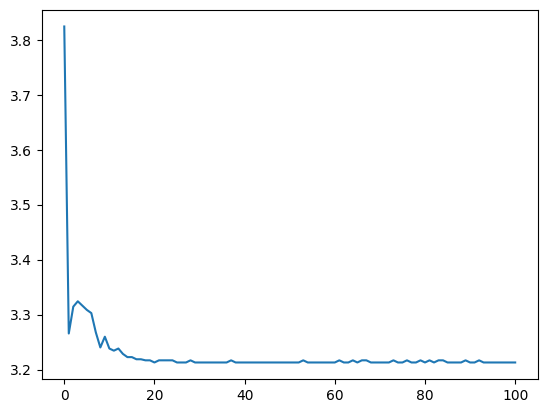

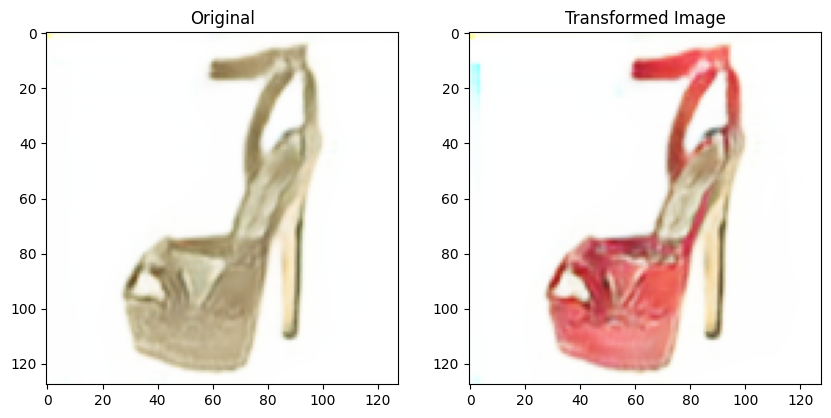

In [ ]:
%matplotlib inline
import shutil
import torchvision



#torch.manual_seed(20)
z_dim = 8


batch_size = 8
lr = 1e-1
img_save_freq = 5

text = "Red shoe"

output_dir = "/content/CLIP_results_dict"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("USING ", device)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)


generator.eval()
generator.to(device)


latent_shape = (1, z_dim)

latents_init = torch.randn(latent_shape).squeeze(-1).to(device) #inits a latent vector, upon which we perform gradient descent(let's draw from normal dist for ours)
latents = torch.nn.Parameter(latents_init, requires_grad=True)
optimizer = torch.optim.Adam(
    params=[latents],
    lr=lr,
    betas=(0.9, 0.999),
)


def tensor_to_pil_img(img):
    img = (img.clamp(-1, 1) + 1) / 2.0
    img = img[0].permute(1, 2, 0).detach().cpu().numpy() * 255
    img = Image.fromarray(img.astype('uint8'))
    return img


clip_transform = torchvision.transforms.Compose([
    clip_preprocess.transforms[4],
])

ref_img_path = None

if ref_img_path is None:
    dataset = Edge2Shoe("/content/train/")
    loader = torch.utils.data.DataLoader(dataset, batch_size=8)
    for data in loader:
        sketch,colored = data
        break
    sketch = norm(sketch).to(gpu_id)

else:
    raise Exception("Not defined")

clip_normalize = torchvision.transforms.Normalize(
    mean=(0.48145466, 0.4578275, 0.40821073),
    std=(0.26862954, 0.26130258, 0.27577711),
)

def compute_clip_loss(img, text):
    img = clip_transform(img)
    img = torch.nn.functional.upsample_bilinear(img, (224, 224)) #resize since clip original resize non differentiable
    tokenized_text = clip.tokenize([text]).to(device)
    img_logits, _text_logits = clip_model(img, tokenized_text)

    return 1/img_logits * 100

counter = 0


try:
    shutil.rmtree("/content/CLIP_results_dict")
except Exception as e:
    print("exception",e)
    pass

os.mkdir("/content/CLIP_results_dict")

loss_list = []
for counter in tqdm(range(501)):
# while True:
    sketches = sketch[1].repeat(1,1,1,1).to(gpu_id)
    out = generator(sketches,latents)
    loss = compute_clip_loss(out,text)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if counter % img_save_freq == 0:
        img = tensor_to_pil_img(out)
        img.save(os.path.join(output_dir, f'{counter}.png'))

        print(f'Step {counter}')
        print(f'Loss {loss.data.cpu().numpy()[0][0]}')
        loss_list.append(loss.data.cpu().numpy()[0][0])
    counter += 1
    # if counter >= 501:
    #     break

plt.plot(loss_list)
plt.show()

img0 = Image.open(os.path.join('/content/CLIP_results_dict','0.png'))
img500 = Image.open(os.path.join('/content/CLIP_results_dict','500.png'))

fig, axs = plt.subplots(1,2, figsize = (10,20
                                            ))
axs[0].imshow(img0)
axs[0].set_title('Original')

axs[1].imshow(img500)
axs[1].set_title('Transformed Image')

plt.show()


Below our prompt is "Metallic Shoe"

USING  cuda



  0%|          | 2/501 [00:00<00:41, 12.11it/s]

Step 0
Loss 3.412109375



  2%|▏         | 8/501 [00:00<00:39, 12.34it/s]

Step 5
Loss 3.37890625



  2%|▏         | 12/501 [00:00<00:37, 12.90it/s]

Step 10
Loss 3.38671875



  4%|▎         | 18/501 [00:01<00:37, 12.92it/s]

Step 15
Loss 3.40234375



  4%|▍         | 22/501 [00:01<00:36, 13.21it/s]

Step 20
Loss 3.40625



  6%|▌         | 28/501 [00:02<00:35, 13.38it/s]

Step 25
Loss 3.40234375



  6%|▋         | 32/501 [00:02<00:35, 13.09it/s]

Step 30
Loss 3.380859375



  8%|▊         | 38/501 [00:02<00:34, 13.25it/s]

Step 35
Loss 3.3046875



  8%|▊         | 42/501 [00:03<00:35, 12.93it/s]

Step 40
Loss 3.302734375



 10%|▉         | 48/501 [00:03<00:34, 13.11it/s]

Step 45
Loss 3.38671875



 10%|█         | 52/501 [00:04<00:33, 13.24it/s]

Step 50
Loss 3.38671875



 12%|█▏        | 58/501 [00:04<00:34, 13.03it/s]

Step 55
Loss 3.380859375



 12%|█▏        | 62/501 [00:04<00:32, 13.34it/s]

Step 60
Loss 3.3046875



 14%|█▎        | 68/501 [00:05<00:31, 13.58it/s]

Step 65
Loss 3.296875



 14%|█▍        | 72/501 [00:05<00:33, 12.97it/s]

Step 70
Loss 3.30859375



 16%|█▌        | 78/501 [00:05<00:32, 13.19it/s]

Step 75
Loss 3.296875



 16%|█▋        | 82/501 [00:06<00:31, 13.33it/s]

Step 80
Loss 3.298828125



 18%|█▊        | 88/501 [00:06<00:31, 13.03it/s]

Step 85
Loss 3.296875



 18%|█▊        | 92/501 [00:07<00:31, 13.09it/s]

Step 90
Loss 3.29296875



 20%|█▉        | 98/501 [00:07<00:30, 13.38it/s]

Step 95
Loss 3.2890625



 20%|██        | 102/501 [00:07<00:31, 12.86it/s]

Step 100
Loss 3.283203125



 22%|██▏       | 108/501 [00:08<00:36, 10.90it/s]

Step 105
Loss 3.287109375



 22%|██▏       | 112/501 [00:08<00:36, 10.57it/s]

Step 110
Loss 3.275390625



 24%|██▎       | 118/501 [00:09<00:38, 10.06it/s]

Step 115
Loss 3.275390625



 24%|██▍       | 122/501 [00:09<00:38,  9.74it/s]

Step 120
Loss 3.283203125



 26%|██▌       | 128/501 [00:10<00:31, 11.75it/s]

Step 125
Loss 3.359375



 26%|██▋       | 132/501 [00:10<00:29, 12.59it/s]

Step 130
Loss 3.365234375



 28%|██▊       | 138/501 [00:11<00:27, 13.19it/s]

Step 135
Loss 3.341796875



 28%|██▊       | 142/501 [00:11<00:26, 13.38it/s]

Step 140
Loss 3.27734375



 30%|██▉       | 148/501 [00:11<00:26, 13.21it/s]

Step 145
Loss 3.271484375



 30%|███       | 152/501 [00:12<00:26, 13.18it/s]

Step 150
Loss 3.275390625



 32%|███▏      | 158/501 [00:12<00:25, 13.46it/s]

Step 155
Loss 3.2890625



 32%|███▏      | 162/501 [00:12<00:25, 13.10it/s]

Step 160
Loss 3.27734375



 34%|███▎      | 168/501 [00:13<00:25, 13.02it/s]

Step 165
Loss 3.267578125



 34%|███▍      | 172/501 [00:13<00:24, 13.29it/s]

Step 170
Loss 3.267578125



 36%|███▌      | 178/501 [00:14<00:24, 12.99it/s]

Step 175
Loss 3.28125



 36%|███▋      | 182/501 [00:14<00:24, 13.28it/s]

Step 180
Loss 3.267578125



 38%|███▊      | 188/501 [00:14<00:23, 13.61it/s]

Step 185
Loss 3.26171875



 38%|███▊      | 192/501 [00:15<00:22, 13.66it/s]

Step 190
Loss 3.26171875



 40%|███▉      | 198/501 [00:15<00:22, 13.56it/s]

Step 195
Loss 3.26171875



 40%|████      | 202/501 [00:15<00:22, 13.16it/s]

Step 200
Loss 3.26171875



 42%|████▏     | 208/501 [00:16<00:22, 13.13it/s]

Step 205
Loss 3.265625



 42%|████▏     | 212/501 [00:16<00:24, 11.63it/s]

Step 210
Loss 3.275390625



 43%|████▎     | 216/501 [00:17<00:27, 10.34it/s]


Step 215
Loss 3.271484375


 44%|████▍     | 222/501 [00:17<00:27, 10.28it/s]

Step 220
Loss 3.33203125



 46%|████▌     | 228/501 [00:18<00:27, 10.09it/s]

Step 225
Loss 3.296875



 47%|████▋     | 233/501 [00:18<00:27,  9.90it/s]

Step 230
Loss 3.267578125



 48%|████▊     | 238/501 [00:19<00:24, 10.64it/s]

Step 235
Loss 3.298828125



 48%|████▊     | 242/501 [00:19<00:21, 12.07it/s]

Step 240
Loss 3.271484375



 49%|████▉     | 246/501 [00:19<00:20, 12.42it/s]

Step 245
Loss 3.267578125



 50%|█████     | 252/501 [00:20<00:23, 10.60it/s]

Step 250
Loss 3.267578125



 51%|█████     | 256/501 [00:20<00:23, 10.25it/s]

Step 255
Loss 3.271484375



 52%|█████▏    | 262/501 [00:21<00:24,  9.88it/s]


Step 260
Loss 3.26171875


 53%|█████▎    | 268/501 [00:22<00:22, 10.53it/s]

Step 265
Loss 3.265625



 54%|█████▍    | 272/501 [00:22<00:19, 11.98it/s]

Step 270
Loss 3.265625



 55%|█████▌    | 278/501 [00:22<00:17, 12.67it/s]

Step 275
Loss 3.29296875



 56%|█████▋    | 282/501 [00:23<00:17, 12.82it/s]

Step 280
Loss 3.31640625



 57%|█████▋    | 288/501 [00:23<00:16, 12.90it/s]

Step 285
Loss 3.296875



 58%|█████▊    | 292/501 [00:23<00:15, 13.19it/s]

Step 290
Loss 3.267578125



 59%|█████▉    | 298/501 [00:24<00:15, 13.28it/s]

Step 295
Loss 3.265625



 60%|██████    | 302/501 [00:24<00:14, 13.30it/s]

Step 300
Loss 3.265625



 61%|██████▏   | 308/501 [00:25<00:14, 12.99it/s]

Step 305
Loss 3.26171875



 62%|██████▏   | 312/501 [00:25<00:14, 13.16it/s]

Step 310
Loss 3.26171875



 63%|██████▎   | 318/501 [00:25<00:13, 13.25it/s]

Step 315
Loss 3.271484375



 64%|██████▍   | 322/501 [00:26<00:13, 13.06it/s]

Step 320
Loss 3.265625



 65%|██████▌   | 328/501 [00:26<00:13, 12.72it/s]

Step 325
Loss 3.271484375



 66%|██████▋   | 332/501 [00:27<00:13, 12.74it/s]

Step 330
Loss 3.267578125



 67%|██████▋   | 338/501 [00:27<00:12, 12.92it/s]

Step 335
Loss 3.27734375



 68%|██████▊   | 342/501 [00:27<00:12, 13.11it/s]

Step 340
Loss 3.267578125



 69%|██████▉   | 348/501 [00:28<00:11, 12.98it/s]

Step 345
Loss 3.2890625



 70%|███████   | 352/501 [00:28<00:11, 13.08it/s]

Step 350
Loss 3.275390625



 71%|███████▏  | 358/501 [00:29<00:10, 13.23it/s]

Step 355
Loss 3.28125



 72%|███████▏  | 362/501 [00:29<00:10, 13.21it/s]

Step 360
Loss 3.271484375



 73%|███████▎  | 368/501 [00:29<00:10, 12.97it/s]

Step 365
Loss 3.267578125



 74%|███████▍  | 372/501 [00:30<00:09, 13.10it/s]

Step 370
Loss 3.259765625



 75%|███████▌  | 378/501 [00:30<00:09, 13.11it/s]

Step 375
Loss 3.259765625



 76%|███████▌  | 382/501 [00:30<00:08, 13.36it/s]

Step 380
Loss 3.25390625



 77%|███████▋  | 388/501 [00:31<00:08, 13.33it/s]

Step 385
Loss 3.259765625



 78%|███████▊  | 392/501 [00:31<00:08, 13.21it/s]

Step 390
Loss 3.2890625



 79%|███████▉  | 396/501 [00:31<00:08, 12.93it/s]

Step 395
Loss 3.275390625



 80%|████████  | 402/501 [00:32<00:09, 10.76it/s]

Step 400
Loss 3.275390625



 81%|████████▏ | 408/501 [00:33<00:08, 10.42it/s]

Step 405
Loss 3.29296875



 82%|████████▏ | 412/501 [00:33<00:09,  9.83it/s]

Step 410
Loss 3.28125



 83%|████████▎ | 418/501 [00:34<00:08, 10.10it/s]

Step 415
Loss 3.28125



 84%|████████▍ | 422/501 [00:34<00:06, 11.62it/s]

Step 420
Loss 3.275390625



 85%|████████▌ | 428/501 [00:34<00:05, 12.83it/s]

Step 425
Loss 3.267578125



 86%|████████▌ | 432/501 [00:35<00:05, 13.18it/s]

Step 430
Loss 3.267578125



 87%|████████▋ | 438/501 [00:35<00:04, 13.11it/s]

Step 435
Loss 3.259765625



 88%|████████▊ | 442/501 [00:35<00:04, 13.28it/s]

Step 440
Loss 3.267578125



 89%|████████▉ | 448/501 [00:36<00:04, 13.07it/s]

Step 445
Loss 3.283203125



 90%|█████████ | 452/501 [00:36<00:03, 12.86it/s]

Step 450
Loss 3.296875



 91%|█████████▏| 458/501 [00:37<00:03, 12.94it/s]

Step 455
Loss 3.26171875



 92%|█████████▏| 462/501 [00:37<00:03, 12.77it/s]

Step 460
Loss 3.259765625



 93%|█████████▎| 468/501 [00:38<00:02, 12.87it/s]

Step 465
Loss 3.259765625



 94%|█████████▍| 472/501 [00:38<00:02, 10.44it/s]

Step 470
Loss 3.259765625



 95%|█████████▌| 477/501 [00:39<00:02,  8.84it/s]

Step 475
Loss 3.267578125



 96%|█████████▌| 482/501 [00:39<00:02,  7.46it/s]

Step 480
Loss 3.259765625



 97%|█████████▋| 487/501 [00:40<00:01,  7.04it/s]

Step 485
Loss 3.271484375



 98%|█████████▊| 492/501 [00:41<00:01,  7.77it/s]

Step 490
Loss 3.27734375



 99%|█████████▉| 497/501 [00:41<00:00,  7.74it/s]

Step 495
Loss 3.26171875



100%|██████████| 501/501 [00:42<00:00, 11.84it/s]


Step 500
Loss 3.259765625


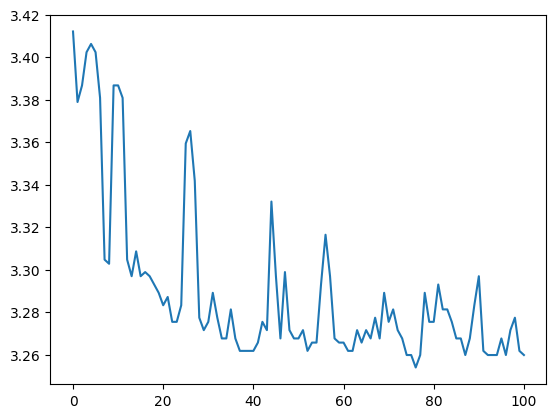

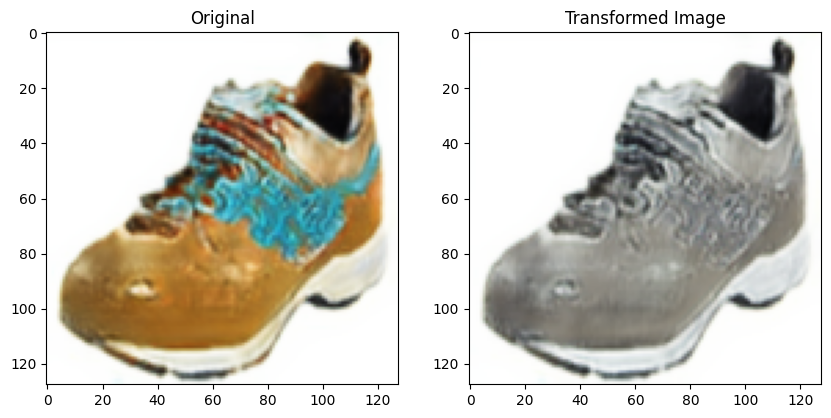

In [ ]:
%matplotlib inline
import shutil
import torchvision



#torch.manual_seed(20)
z_dim = 8


batch_size = 8
lr = 1e-1
img_save_freq = 5

text = "metallic shoe"

output_dir = "/content/CLIP_results_dict"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("USING ", device)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)


generator.eval()
generator.to(device)


latent_shape = (1, z_dim)

latents_init = torch.randn(latent_shape).squeeze(-1).to(device) #inits a latent vector, upon which we perform gradient descent(let's draw from normal dist for ours)
latents = torch.nn.Parameter(latents_init, requires_grad=True)
optimizer = torch.optim.Adam(
    params=[latents],
    lr=lr,
    betas=(0.9, 0.999),
)


def tensor_to_pil_img(img):
    img = (img.clamp(-1, 1) + 1) / 2.0
    img = img[0].permute(1, 2, 0).detach().cpu().numpy() * 255
    img = Image.fromarray(img.astype('uint8'))
    return img


clip_transform = torchvision.transforms.Compose([
    clip_preprocess.transforms[4],
])

ref_img_path = None

if ref_img_path is None:
    dataset = Edge2Shoe("/content/train/")
    loader = torch.utils.data.DataLoader(dataset, batch_size=8)
    for data in loader:
        sketch,colored = data
        break
    sketch = norm(sketch).to(gpu_id)

else:
    raise Exception("Not defined")

clip_normalize = torchvision.transforms.Normalize(
    mean=(0.48145466, 0.4578275, 0.40821073),
    std=(0.26862954, 0.26130258, 0.27577711),
)

def compute_clip_loss(img, text):
    img = clip_transform(img)
    img = torch.nn.functional.upsample_bilinear(img, (224, 224)) #resize since clip original resize non differentiable
    tokenized_text = clip.tokenize([text]).to(device)
    img_logits, _text_logits = clip_model(img, tokenized_text)

    return 1/img_logits * 100

counter = 0


try:
    shutil.rmtree("/content/CLIP_results_dict")
except Exception as e:
    print("exception",e)
    pass

os.mkdir("/content/CLIP_results_dict")

loss_list = []
for counter in tqdm(range(501)):
# while True:
    sketches = sketch[4].repeat(1,1,1,1).to(gpu_id)
    out = generator(sketches,latents)
    loss = compute_clip_loss(out,text)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if counter % img_save_freq == 0:
        img = tensor_to_pil_img(out)
        img.save(os.path.join(output_dir, f'{counter}.png'))

        print(f'Step {counter}')
        print(f'Loss {loss.data.cpu().numpy()[0][0]}')
        loss_list.append(loss.data.cpu().numpy()[0][0])
    counter += 1
    # if counter >= 501:
    #     break

plt.plot(loss_list)
plt.show()

img0 = Image.open(os.path.join('/content/CLIP_results_dict','0.png'))
img500 = Image.open(os.path.join('/content/CLIP_results_dict','500.png'))

fig, axs = plt.subplots(1,2, figsize = (10,20
                                            ))
axs[0].imshow(img0)
axs[0].set_title('Original')

axs[1].imshow(img500)
axs[1].set_title('Transformed Image')

plt.show()


**We find that not just color based prompts but other descriptive prompts, like 'metallic' also work well**